In [36]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import logging
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # For formatting axes if needed
import os # Import os module for directory operations
import re # Import re for cleaning filenames

# Define a colormap with distinct colors for each city
import matplotlib.colors as mcolors
from cycler import cycler

# Suppress excessive logging and warnings
warnings.filterwarnings('ignore')
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [37]:
# Create a list of distinct colors for the cities
distinct_colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#bcbd22',  # olive
    '#17becf',  # cyan
    # '#ff9896',  # light red
    # '#98df8a',  # light green
    # '#aec7e8',  # light blue
    '#ffbb78',  # light orange
    '#d62728',  # red
]

In [38]:
raw_data = pd.read_excel('nuoc_ngoai.xlsx')
raw_data

,Thành phố (Quốc gia),2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP),2019 (GDP Quốc gia),2020 (GDP Quốc gia),2021 (GDP Quốc gia),2022 (GDP Quốc gia),2023 (GDP Quốc gia),2019 (Growth rate),2020 (Growth rate),2021 (Growth rate),2022 (Growth rate),Average growth rate
0,Jakarta (Indonesia),199.0,189.8,203.7,202.6,225.9,1119.10,1059.10,1186.50,1319.10,1371.20,-0.053615,0.120291,0.111757,0.039497,0.054483
1,Bangkok (Thái Lan),173.8,150.0,155.0,149.0,154.0,543.98,500.46,506.26,495.65,514.97,-0.080003,0.011589,-0.020958,0.038979,-0.012598
2,Singapore (Singapore),376.9,349.5,434.1,498.5,501.4,376.90,349.50,434.10,498.50,501.40,-0.072698,0.242060,0.148353,0.005817,0.080883
3,Manila (Philippines),119.7,121.2,117.7,113.8,118.8,376.80,361.80,394.10,404.40,437.10,-0.039809,0.089276,0.026135,0.080861,0.039116
4,Kuala Lumpur (Malaysia),55.6,51.7,53.0,54.5,56.7,365.18,337.46,373.79,407.61,399.71,-0.075908,0.107657,0.090479,-0.019381,0.025712
5,Hong Kong (Trung Quốc),363.1,344.9,369.0,358.7,380.8,14280.00,14687.00,17820.00,17882.00,17795.00,0.028501,0.213318,0.003479,-0.004865,0.060108
6,Seoul (Hàn Quốc),374.0,370.0,405.0,412.0,421.0,1642.00,1631.00,1800.00,1674.00,1713.00,-0.006699,0.103617,-0.070000,0.023297,0.012554
7,Taipei (Đài Loan),91.0,90.0,98.0,100.0,105.0,610.00,635.00,773.00,772.00,755.00,0.040984,0.217323,-0.001294,-0.022021,0.058748
8,Bắc Kinh (Trung Quốc),511.6,484.0,547.0,671.9,672.0,14280.00,14687.00,17820.00,17882.00,17795.00,0.028501,0.213318,0.003479,-0.004865,0.060108
9,Thượng Hải (Trung Quốc),550.0,520.0,600.0,590.0,610.0,14280.00,14687.00,17820.00,17882.00,17795.00,0.028501,0.213318,0.003479,-0.004865,0.060108


In [39]:
exculde_cities = ['Bắc Kinh (Trung Quốc)', 'Thượng Hải (Trung Quốc)', 'Tokyo (Nhật Bản)']

In [40]:
raw_data = raw_data[~raw_data['Thành phố (Quốc gia)'].isin(exculde_cities)].reset_index(drop=True)
raw_data

,Thành phố (Quốc gia),2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP),2019 (GDP Quốc gia),2020 (GDP Quốc gia),2021 (GDP Quốc gia),2022 (GDP Quốc gia),2023 (GDP Quốc gia),2019 (Growth rate),2020 (Growth rate),2021 (Growth rate),2022 (Growth rate),Average growth rate
0,Jakarta (Indonesia),199.0,189.8,203.7,202.6,225.9,1119.10,1059.10,1186.50,1319.10,1371.20,-0.053615,0.120291,0.111757,0.039497,0.054483
1,Bangkok (Thái Lan),173.8,150.0,155.0,149.0,154.0,543.98,500.46,506.26,495.65,514.97,-0.080003,0.011589,-0.020958,0.038979,-0.012598
2,Singapore (Singapore),376.9,349.5,434.1,498.5,501.4,376.90,349.50,434.10,498.50,501.40,-0.072698,0.242060,0.148353,0.005817,0.080883
3,Manila (Philippines),119.7,121.2,117.7,113.8,118.8,376.80,361.80,394.10,404.40,437.10,-0.039809,0.089276,0.026135,0.080861,0.039116
4,Kuala Lumpur (Malaysia),55.6,51.7,53.0,54.5,56.7,365.18,337.46,373.79,407.61,399.71,-0.075908,0.107657,0.090479,-0.019381,0.025712
5,Hong Kong (Trung Quốc),363.1,344.9,369.0,358.7,380.8,14280.00,14687.00,17820.00,17882.00,17795.00,0.028501,0.213318,0.003479,-0.004865,0.060108
6,Seoul (Hàn Quốc),374.0,370.0,405.0,412.0,421.0,1642.00,1631.00,1800.00,1674.00,1713.00,-0.006699,0.103617,-0.070000,0.023297,0.012554
7,Taipei (Đài Loan),91.0,90.0,98.0,100.0,105.0,610.00,635.00,773.00,772.00,755.00,0.040984,0.217323,-0.001294,-0.022021,0.058748
8,Thâm Quyến (Trung Quốc),381.4,374.0,450.0,470.0,500.0,14280.00,14687.00,17820.00,17882.00,17795.00,0.028501,0.213318,0.003479,-0.004865,0.060108
9,Osaka (Nhật Bản),377.9,350.0,330.0,300.0,290.0,5328.00,5038.00,5035.00,4256.00,4460.00,-0.054429,-0.000595,-0.154717,0.047932,-0.040452


In [41]:
hcm_data = pd.read_csv('hcm.csv')
hcm_data

,Năm,Quy mô GRDP (GDP) giá hiện hành HCM (New) (Đơn vị: Tỷ đồng) (Mã số: 10)
0,2019,2051780
1,2020,2055017
2,2021,2067397
3,2022,2346329
4,2023,2500589


In [42]:
hcm_data['TP. Hồ Chí Minh (Việt Nam)'] = hcm_data['Quy mô GRDP (GDP) giá hiện hành HCM (New) (Đơn vị: Tỷ đồng) (Mã số: 10)']
hcm_data = hcm_data[['Năm', 'TP. Hồ Chí Minh (Việt Nam)']]
hcm_data

,Năm,TP. Hồ Chí Minh (Việt Nam)
0,2019,2051780
1,2020,2055017
2,2021,2067397
3,2022,2346329
4,2023,2500589


In [43]:
# add (GRDP) to every value of ['Năm']
hcm_data['Năm'] = hcm_data['Năm'].astype(str) + ' (GRDP)'
hcm_data

,Năm,TP. Hồ Chí Minh (Việt Nam)
0,2019 (GRDP),2051780
1,2020 (GRDP),2055017
2,2021 (GRDP),2067397
3,2022 (GRDP),2346329
4,2023 (GRDP),2500589


In [44]:
hcm_data = hcm_data.transpose()
hcm_data

,0,1,2,3,4
Năm,2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP)
TP. Hồ Chí Minh (Việt Nam),2051780,2055017,2067397,2346329,2500589


In [45]:
hcm_data.columns = hcm_data.iloc[0]
hcm_data

Năm,2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP)
Năm,2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP)
TP. Hồ Chí Minh (Việt Nam),2051780,2055017,2067397,2346329,2500589


In [46]:
hcm_data = hcm_data.iloc[1:]
hcm_data

Năm,2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP)
TP. Hồ Chí Minh (Việt Nam),2051780,2055017,2067397,2346329,2500589


In [47]:
hcm_data['Thành phố (Quốc gia)'] = 'TP. Hồ Chí Minh (Việt Nam)'

In [48]:
hcm_data.index = [0]
hcm_data

Năm,2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP),Thành phố (Quốc gia)
0,2051780,2055017,2067397,2346329,2500589,TP. Hồ Chí Minh (Việt Nam)


In [49]:
cols_to_divide = hcm_data.columns.drop('Thành phố (Quốc gia)')
hcm_data[cols_to_divide] = hcm_data[cols_to_divide] / 26000
hcm_data

Năm,2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP),Thành phố (Quốc gia)
0,78.914615,79.039115,79.515269,90.243423,96.1765,TP. Hồ Chí Minh (Việt Nam)


In [50]:
cities_grdp_cols = ['Thành phố (Quốc gia)', '2019 (GRDP)', '2020 (GRDP)', '2021 (GRDP)', '2022 (GRDP)', '2023 (GRDP)']
country_gdp_cols = ['Thành phố (Quốc gia)', '2019 (GDP Quốc gia)', '2020 (GDP Quốc gia)', '2021 (GDP Quốc gia)', '2022 (GDP Quốc gia)', '2023 (GDP Quốc gia)']
growth_cols = ['Thành phố (Quốc gia)', '2019 (Growth rate)', '2020 (Growth rate)', '2021 (Growth rate)', '2022 (Growth rate)', 'Average growth rate']

In [51]:
cities_grdp_df = raw_data.loc[:, cities_grdp_cols]
country_gdp_df = raw_data.loc[:, country_gdp_cols]
growth_df = raw_data.loc[:, growth_cols]

In [52]:
cities_grdp_df

,Thành phố (Quốc gia),2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP)
0,Jakarta (Indonesia),199.0,189.8,203.7,202.6,225.9
1,Bangkok (Thái Lan),173.8,150.0,155.0,149.0,154.0
2,Singapore (Singapore),376.9,349.5,434.1,498.5,501.4
3,Manila (Philippines),119.7,121.2,117.7,113.8,118.8
4,Kuala Lumpur (Malaysia),55.6,51.7,53.0,54.5,56.7
5,Hong Kong (Trung Quốc),363.1,344.9,369.0,358.7,380.8
6,Seoul (Hàn Quốc),374.0,370.0,405.0,412.0,421.0
7,Taipei (Đài Loan),91.0,90.0,98.0,100.0,105.0
8,Thâm Quyến (Trung Quốc),381.4,374.0,450.0,470.0,500.0
9,Osaka (Nhật Bản),377.9,350.0,330.0,300.0,290.0


In [53]:
cities_grdp_df = pd.concat([hcm_data, cities_grdp_df]).reset_index(drop=True)
cities_grdp_df

,2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP),Thành phố (Quốc gia)
0,78.914615,79.039115,79.515269,90.243423,96.1765,TP. Hồ Chí Minh (Việt Nam)
1,199.0,189.8,203.7,202.6,225.9,Jakarta (Indonesia)
2,173.8,150.0,155.0,149.0,154.0,Bangkok (Thái Lan)
3,376.9,349.5,434.1,498.5,501.4,Singapore (Singapore)
4,119.7,121.2,117.7,113.8,118.8,Manila (Philippines)
5,55.6,51.7,53.0,54.5,56.7,Kuala Lumpur (Malaysia)
6,363.1,344.9,369.0,358.7,380.8,Hong Kong (Trung Quốc)
7,374.0,370.0,405.0,412.0,421.0,Seoul (Hàn Quốc)
8,91.0,90.0,98.0,100.0,105.0,Taipei (Đài Loan)
9,381.4,374.0,450.0,470.0,500.0,Thâm Quyến (Trung Quốc)


In [54]:
new_columns = {col: col.replace(' (GRDP)', '') for col in cities_grdp_df.columns if '(GRDP)' in col}
cities_grdp_df = cities_grdp_df.rename(columns=new_columns)
cities_grdp_df

,2019,2020,2021,2022,2023,Thành phố (Quốc gia)
0,78.914615,79.039115,79.515269,90.243423,96.1765,TP. Hồ Chí Minh (Việt Nam)
1,199.0,189.8,203.7,202.6,225.9,Jakarta (Indonesia)
2,173.8,150.0,155.0,149.0,154.0,Bangkok (Thái Lan)
3,376.9,349.5,434.1,498.5,501.4,Singapore (Singapore)
4,119.7,121.2,117.7,113.8,118.8,Manila (Philippines)
5,55.6,51.7,53.0,54.5,56.7,Kuala Lumpur (Malaysia)
6,363.1,344.9,369.0,358.7,380.8,Hong Kong (Trung Quốc)
7,374.0,370.0,405.0,412.0,421.0,Seoul (Hàn Quốc)
8,91.0,90.0,98.0,100.0,105.0,Taipei (Đài Loan)
9,381.4,374.0,450.0,470.0,500.0,Thâm Quyến (Trung Quốc)


In [55]:
cities_grdp_df = pd.read_excel('tong_hop.xlsx')
cities_grdp_df

,Năm,Jakarta (Indonesia),Bangkok (Thái Lan),Singapore (Singapore),Manila (Philippines),Kuala Lumpur (Malaysia),Hong Kong (Trung Quốc),Seoul (Hàn Quốc),Taipei (Đài Loan),Thâm Quyến (Trung Quốc),Osaka (Nhật Bản),TP. Hồ Chí Minh (Việt Nam)
0,2019,199.0,173.8,376.9,119.7,55.6,363.1,374,91,381.4,377.9,78.914615
1,2020,189.8,150.0,349.5,121.2,51.7,344.9,370,90,374.0,350.0,79.039115
2,2021,203.7,155.0,434.1,117.7,53.0,369.0,405,98,450.0,330.0,79.515269
3,2022,202.6,149.0,498.5,113.8,54.5,358.7,412,100,470.0,300.0,90.243423
4,2023,225.9,154.0,501.4,118.8,56.7,380.8,421,105,500.0,290.0,96.176500


In [56]:
cities_grdp_df.set_index('Năm',inplace=True, drop=False)
cities_grdp_df


,Năm,Jakarta (Indonesia),Bangkok (Thái Lan),Singapore (Singapore),Manila (Philippines),Kuala Lumpur (Malaysia),Hong Kong (Trung Quốc),Seoul (Hàn Quốc),Taipei (Đài Loan),Thâm Quyến (Trung Quốc),Osaka (Nhật Bản),TP. Hồ Chí Minh (Việt Nam)
Năm,,,,,,,,,,,,
2019,2019,199.0,173.8,376.9,119.7,55.6,363.1,374,91,381.4,377.9,78.914615
2020,2020,189.8,150.0,349.5,121.2,51.7,344.9,370,90,374.0,350.0,79.039115
2021,2021,203.7,155.0,434.1,117.7,53.0,369.0,405,98,450.0,330.0,79.515269
2022,2022,202.6,149.0,498.5,113.8,54.5,358.7,412,100,470.0,300.0,90.243423
2023,2023,225.9,154.0,501.4,118.8,56.7,380.8,421,105,500.0,290.0,96.176500


In [57]:
average_growth_df = growth_df[['Thành phố (Quốc gia)', 'Average growth rate']]
average_growth_df

,Thành phố (Quốc gia),Average growth rate
0,Jakarta (Indonesia),0.054483
1,Bangkok (Thái Lan),-0.012598
2,Singapore (Singapore),0.080883
3,Manila (Philippines),0.039116
4,Kuala Lumpur (Malaysia),0.025712
5,Hong Kong (Trung Quốc),0.060108
6,Seoul (Hàn Quốc),0.012554
7,Taipei (Đài Loan),0.058748
8,Thâm Quyến (Trung Quốc),0.060108
9,Osaka (Nhật Bản),-0.040452


In [58]:
forecast_years = np.arange(2024, 2031).reshape(-1, 1)
forecast_years

array([[2024],
       [2025],
       [2026],
       [2027],
       [2028],
       [2029],
       [2030]])

In [59]:
def forecast_linear_regression(series: pd.Series):
    """Forecasts using Linear Regression based on Year."""
    df = series.reset_index()
    df.columns = ['Năm', 'Value']

    # Prepare data for sklearn
    X_train = df['Năm'].values.reshape(-1, 1)
    y_train = df['Value'].values

    # Handle potential NaN/inf values if any exist before fitting
    if not np.all(np.isfinite(y_train)):
         print(f"Warning: Non-finite values found in series {series.name}. Skipping linear regression.")
         return pd.Series(index=forecast_years.flatten(), dtype=float)


    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict
    predictions = model.predict(forecast_years)
    return pd.Series(predictions, index=forecast_years.flatten())

def forecast_fixed_growth(series: pd.Series, growth_rate: float = 0.08):
    """
    Forecasts assuming a fixed compound annual growth rate from the last value.
    
    Args:
        series: Input time series to forecast
        growth_rate: Annual growth rate as a decimal (e.g. 0.08 for 8% growth)
    """
    # Get the last value directly without using loc with the index
    last_value = series.iloc[-1]
    last_year = int(series.index.max())  # Convert to int for calculation

    if not np.isfinite(last_value):
        print(f"Warning: Last value for {series.name} is non-finite. Cannot apply growth forecast.")
        return pd.Series(index=forecast_years.flatten(), dtype=float)

    forecast_values = [
        last_value * ((1 + growth_rate) ** (int(year) - last_year))
        for year in forecast_years.flatten()
    ]
    return pd.Series(forecast_values, index=forecast_years.flatten())

def forecast_exponential_smoothing(series: pd.Series) -> pd.Series:
    """Forecast using Exponential Smoothing Regression."""
    df = series.reset_index()
    df.columns = ['Năm', 'Value']

    # Use a simple additive trend component (no seasonality)
    model = ExponentialSmoothing(
        df['Value'], 
        trend='add',  # Additive trend component
        seasonal=None  # No seasonal component due to limited data
    ).fit()

    # Forecast the next values
    forecast_values = model.forecast(len(forecast_years))
    return forecast_values
    
def forecast_arima(series: pd.Series) -> pd.Series:
    """
    Forecast a time series with ARIMA.
    Falls back to a simpler (0,d,0) model if the default (1,d,1) fails.

    Returns a Series whose index == forecast_years.
    If the series is unusable, returns an all-NaN Series with the same index.
    """
    y = series.copy()
    d = 0

    if y.std() > 1e-9 and adfuller(y)[1] > 0.05:
        d = 1
        diff = y.diff().dropna()
        if diff.std() > 1e-9 and adfuller(diff)[1] > 0.05:
            d = 2

    for order in [(1, d, 1), (0, d, 0)]:
        try:
            fit = ARIMA(
                y, order=order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit()
            fc = fit.get_forecast(len(forecast_years)).predicted_mean
            fc.index = forecast_years.flatten()
            return fc
        except Exception:
            continue

    return pd.Series(index=forecast_years, dtype=float)


def forecast_prophet(series: pd.Series):
    """Forecasts using Facebook Prophet."""
    df = series.reset_index()
    df.columns = ['Năm', 'y']
    df['ds'] = pd.to_datetime(df['Năm'].astype(str) + '-12-31') # Use year-end for annual data

     # Handle potential NaN/inf values
    if not np.all(np.isfinite(df['y'].values)):
         print(f"Warning: Non-finite values found in series {series.name}. Skipping Prophet.")
         return pd.Series(index=forecast_years.flatten(), dtype=float)


    try:
        model = Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
        model.fit(df[['ds', 'y']])

        # Create future dataframe
        future_dates = model.make_future_dataframe(periods=len(forecast_years), freq='A-DEC') # Annual frequency ending Dec 31st
        # Adjust future dates to match target years if needed
        future_dates['year'] = future_dates['ds'].dt.year
        future_dates = future_dates[future_dates['year'].isin(forecast_years.flatten())]


        # Predict
        forecast_result = model.predict(future_dates)
        predictions = forecast_result[['ds', 'yhat']].set_index('ds')['yhat']
        predictions.index = predictions.index.year # Use year as index
        # Ensure all forecast years are present, filling missing ones potentially with NaN
        predictions = predictions.reindex(forecast_years.flatten())
        return predictions
    except Exception as e:
        print(f"Error fitting Prophet for {series.name}: {e}")
        return pd.Series(index=forecast_years.flatten(), dtype=float)

In [60]:
cities_grdp_df

,Năm,Jakarta (Indonesia),Bangkok (Thái Lan),Singapore (Singapore),Manila (Philippines),Kuala Lumpur (Malaysia),Hong Kong (Trung Quốc),Seoul (Hàn Quốc),Taipei (Đài Loan),Thâm Quyến (Trung Quốc),Osaka (Nhật Bản),TP. Hồ Chí Minh (Việt Nam)
Năm,,,,,,,,,,,,
2019,2019,199.0,173.8,376.9,119.7,55.6,363.1,374,91,381.4,377.9,78.914615
2020,2020,189.8,150.0,349.5,121.2,51.7,344.9,370,90,374.0,350.0,79.039115
2021,2021,203.7,155.0,434.1,117.7,53.0,369.0,405,98,450.0,330.0,79.515269
2022,2022,202.6,149.0,498.5,113.8,54.5,358.7,412,100,470.0,300.0,90.243423
2023,2023,225.9,154.0,501.4,118.8,56.7,380.8,421,105,500.0,290.0,96.176500


In [61]:
features_to_forecast = cities_grdp_df.columns.drop(['Năm'])
features_to_forecast

Index(['Jakarta (Indonesia)', 'Bangkok (Thái Lan)', 'Singapore (Singapore)',
       'Manila (Philippines)', 'Kuala Lumpur (Malaysia)',
       'Hong Kong (Trung Quốc)', 'Seoul (Hàn Quốc)', 'Taipei (Đài Loan)',
       'Thâm Quyến (Trung Quốc)', 'Osaka (Nhật Bản)',
       'TP. Hồ Chí Minh (Việt Nam)'],
      dtype='object')

In [62]:
all_inputs = {'foreign_regression': cities_grdp_df}
all_inputs

{'foreign_regression':        Năm  Jakarta (Indonesia)  Bangkok (Thái Lan)  Singapore (Singapore)  \
 Năm                                                                          
 2019  2019                199.0               173.8                  376.9   
 2020  2020                189.8               150.0                  349.5   
 2021  2021                203.7               155.0                  434.1   
 2022  2022                202.6               149.0                  498.5   
 2023  2023                225.9               154.0                  501.4   
 
       Manila (Philippines)  Kuala Lumpur (Malaysia)  Hong Kong (Trung Quốc)  \
 Năm                                                                           
 2019                 119.7                     55.6                   363.1   
 2020                 121.2                     51.7                   344.9   
 2021                 117.7                     53.0                   369.0   
 2022                 1

In [63]:
all_forecasts = {}

In [64]:
# Create a list of features that should be clipped at 0 (non-negative values only)
for name, df in all_inputs.items():
    print(f"--- Forecasting for {name} ---")
    forecasts_by_feature = {}

    # set Năm as integer index and sort
    df_i = df.set_index('Năm').sort_index()

    for feature in features_to_forecast:
        print(f"   Forecasting {feature}...")
        s = df_i[feature].astype(float)

        # skip constant or all‑NaN series
        if s.nunique() <= 1 or not np.any(np.isfinite(s)):
            print(f"      Skipping {feature} for {name}: constant or non‑finite.")
            empty = pd.DataFrame(index=forecast_years.flatten(), 
                                 columns=['Linear Regression','Prophet','10% Growth','8% Growth','Mixed Growth','ARIMA'])
            forecasts_by_feature[feature] = empty
            continue

        # otherwise, do all methods
        df_fc = pd.DataFrame(index=forecast_years.flatten())
        
        # 1) Linear Regression
        lr = forecast_linear_regression(s)
        df_fc['Linear Regression'] = lr

        # 2) Prophet
        pr = forecast_prophet(s)
        df_fc['Prophet'] = pr

        # 3) 10% growth
        g10 = forecast_fixed_growth(s, growth_rate=0.1)
        df_fc['10% Growth'] = g10

        # 4) fixed growth based on city's country average growth rate
        # Get the city name from the feature
        city_name = feature
        # Find the corresponding growth rate from average_growth_df
        if city_name in average_growth_df['Thành phố (Quốc gia)'].values:
            growth_rate = average_growth_df.loc[average_growth_df['Thành phố (Quốc gia)'] == city_name, 'Average growth rate'].values[0]
        else:
            # Default growth rate if city not found
            growth_rate = 0.08
            print(f"      Warning: No growth rate found for {city_name}, using default 8%")
        
        fg = forecast_fixed_growth(s, growth_rate=growth_rate)
        df_fc['GDP Growth'] = fg

        # 6) Exponential Smoothing
        es = forecast_exponential_smoothing(s)
        df_fc['Exponential Smoothing'] = es.values

        # 7) ARIMA
        # try:
        #     s_period = s.copy()
        #     s_period.index = pd.PeriodIndex(s_period.index, freq='A-DEC', name='Năm')
        #     ar = forecast_arima(s_period)
        #     df_fc['ARIMA'] = ar
        # except Exception as e:
        #     print(f"ARIMA failed for {feature} in {name}: {e}")
        #     df_fc['ARIMA'] = np.nan

        forecasts_by_feature[feature] = df_fc

    # concatenate each feature's DataFrame side by side
    all_forecasts[name] = pd.concat(forecasts_by_feature, axis=1)

print("\n--- All forecasting complete ---")

--- Forecasting for foreign_regression ---
   Forecasting Jakarta (Indonesia)...
   Forecasting Bangkok (Thái Lan)...
   Forecasting Singapore (Singapore)...
   Forecasting Manila (Philippines)...
   Forecasting Kuala Lumpur (Malaysia)...
   Forecasting Hong Kong (Trung Quốc)...
   Forecasting Seoul (Hàn Quốc)...
   Forecasting Taipei (Đài Loan)...
   Forecasting Thâm Quyến (Trung Quốc)...
   Forecasting Osaka (Nhật Bản)...
   Forecasting TP. Hồ Chí Minh (Việt Nam)...

--- All forecasting complete ---


In [65]:
all_forecasts

{'foreign_regression':      Jakarta (Indonesia)                                      \
        Linear Regression     Prophet  10% Growth  GDP Growth   
 2024              224.18  224.178107  248.490000  238.207608   
 2025              230.84  230.829479  273.339000  251.185766   
 2026              237.50  237.480850  300.672900  264.871006   
 2027              244.16  244.132222  330.740190  279.301854   
 2028              250.82  250.801817  363.814209  294.518931   
 2029              257.48  257.453189  400.195630  310.565073   
 2030              264.14  264.104561  440.215193  327.485450   
 
                            Bangkok (Thái Lan)                          \
      Exponential Smoothing  Linear Regression     Prophet  10% Growth   
 2024            224.180001             144.18  144.182796  169.400000   
 2025            230.840001             140.12  140.128186  186.340000   
 2026            237.500001             136.06  136.073576  204.974000   
 2027            244.

In [66]:
# Define the output directory
output_dir = 'output_plots_with_table' # Keep same directory
os.makedirs(output_dir, exist_ok=True)

In [67]:
models_for_table = ['Historical','Linear Regression', '10% Growth', 'GDP Growth', 'Exponential Smoothing', 'Prophet']

In [68]:
# Define colors for different models
colors = {
    'Historical': 'black',
    'Linear Regression': 'blue',
    '10% Growth': 'red',
    'GDP Growth': 'yellow',
    'Exponential Smoothing': 'green',
    'Prophet': 'brown'
}

In [69]:
cities_grdp_df

,Năm,Jakarta (Indonesia),Bangkok (Thái Lan),Singapore (Singapore),Manila (Philippines),Kuala Lumpur (Malaysia),Hong Kong (Trung Quốc),Seoul (Hàn Quốc),Taipei (Đài Loan),Thâm Quyến (Trung Quốc),Osaka (Nhật Bản),TP. Hồ Chí Minh (Việt Nam)
Năm,,,,,,,,,,,,
2019,2019,199.0,173.8,376.9,119.7,55.6,363.1,374,91,381.4,377.9,78.914615
2020,2020,189.8,150.0,349.5,121.2,51.7,344.9,370,90,374.0,350.0,79.039115
2021,2021,203.7,155.0,434.1,117.7,53.0,369.0,405,98,450.0,330.0,79.515269
2022,2022,202.6,149.0,498.5,113.8,54.5,358.7,412,100,470.0,300.0,90.243423
2023,2023,225.9,154.0,501.4,118.8,56.7,380.8,421,105,500.0,290.0,96.176500



Processing plots for: foreign_regression
  Saved plot with table: output_plots_with_table\foreign_regression_Jakarta_Indonesia_with_table.png


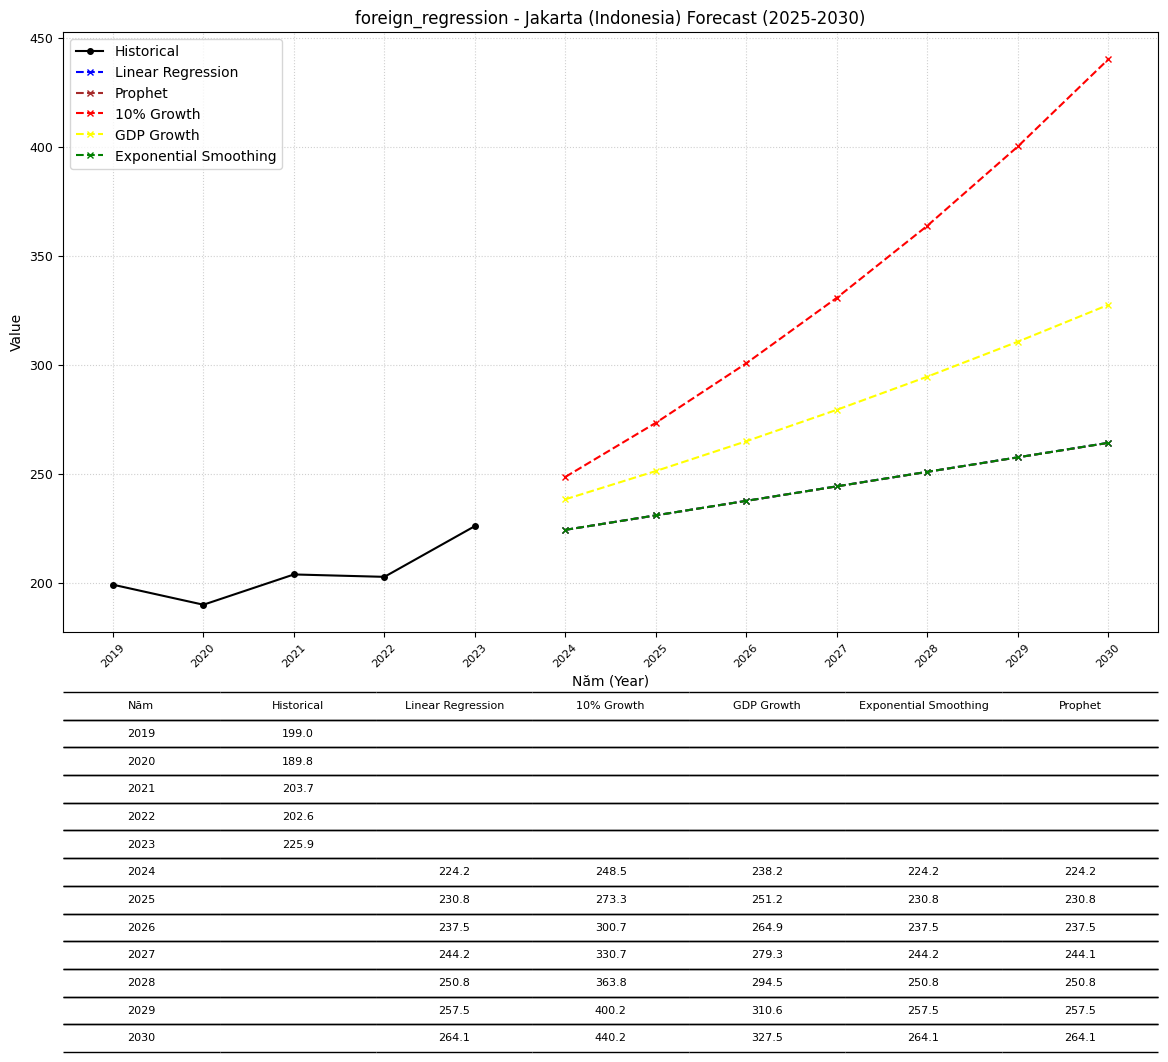

  Saved plot with table: output_plots_with_table\foreign_regression_Bangkok_Thái_Lan_with_table.png


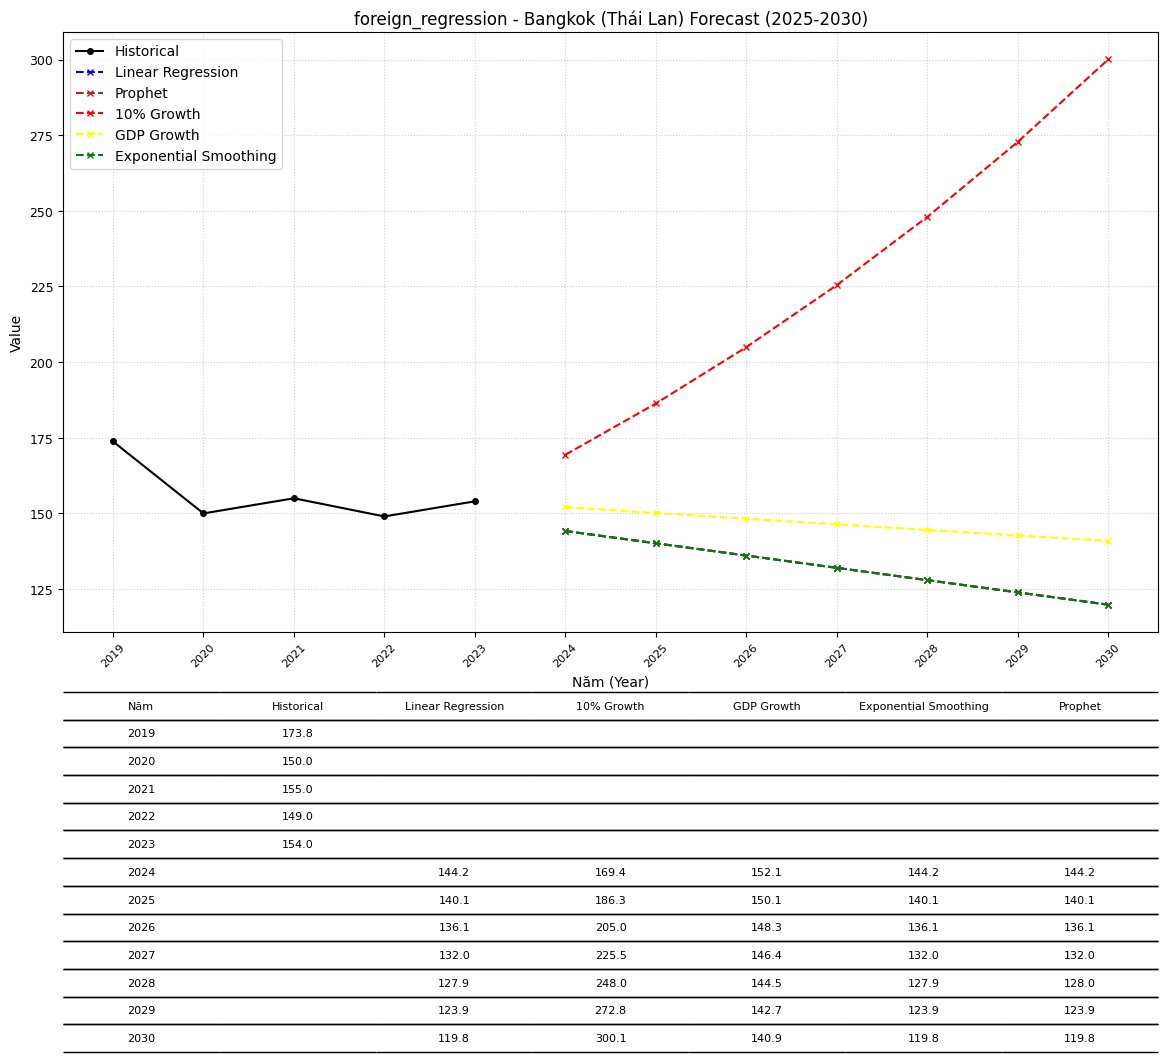

  Saved plot with table: output_plots_with_table\foreign_regression_Singapore_Singapore_with_table.png


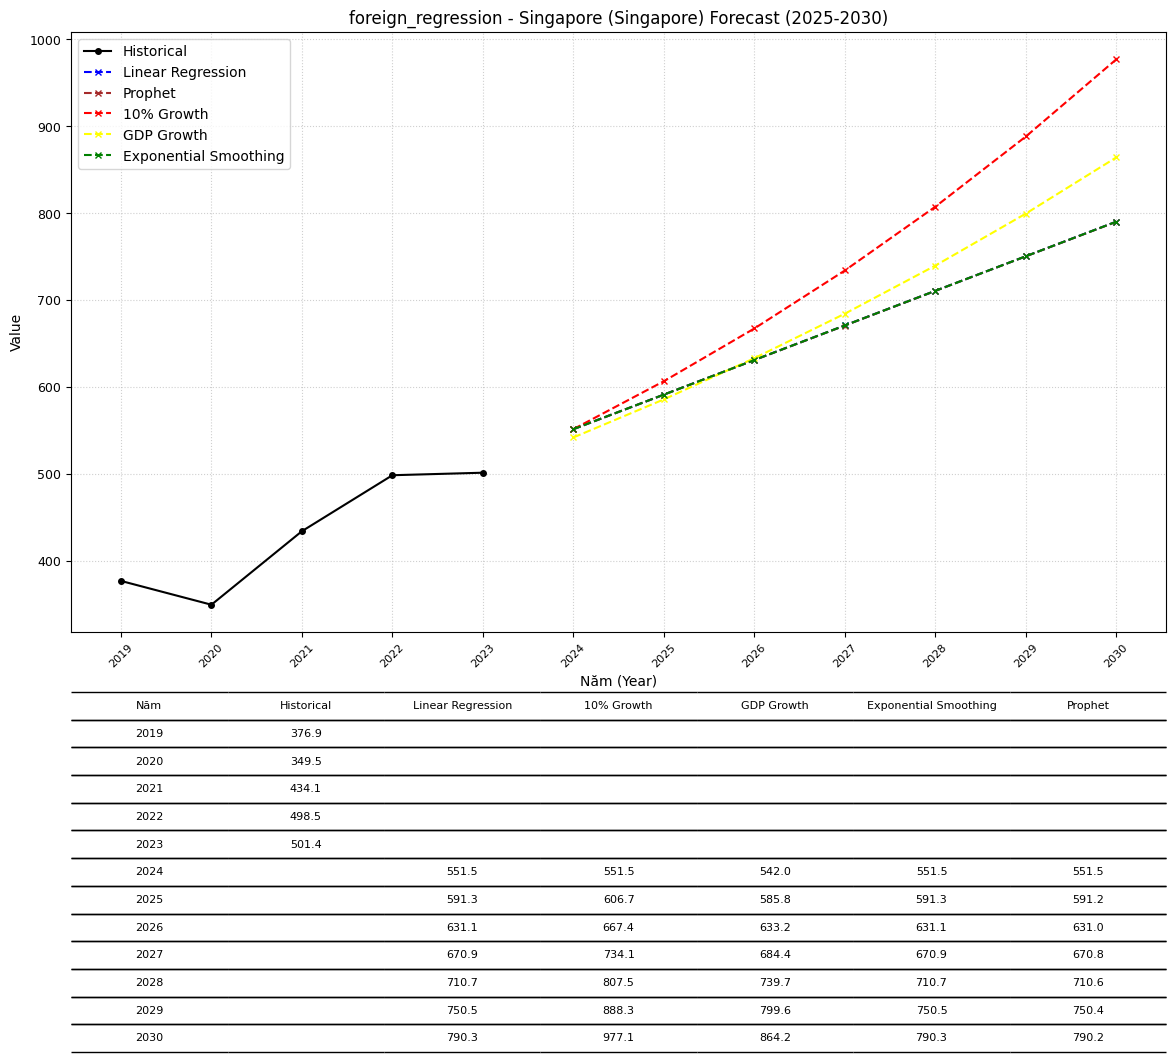

  Saved plot with table: output_plots_with_table\foreign_regression_Manila_Philippines_with_table.png


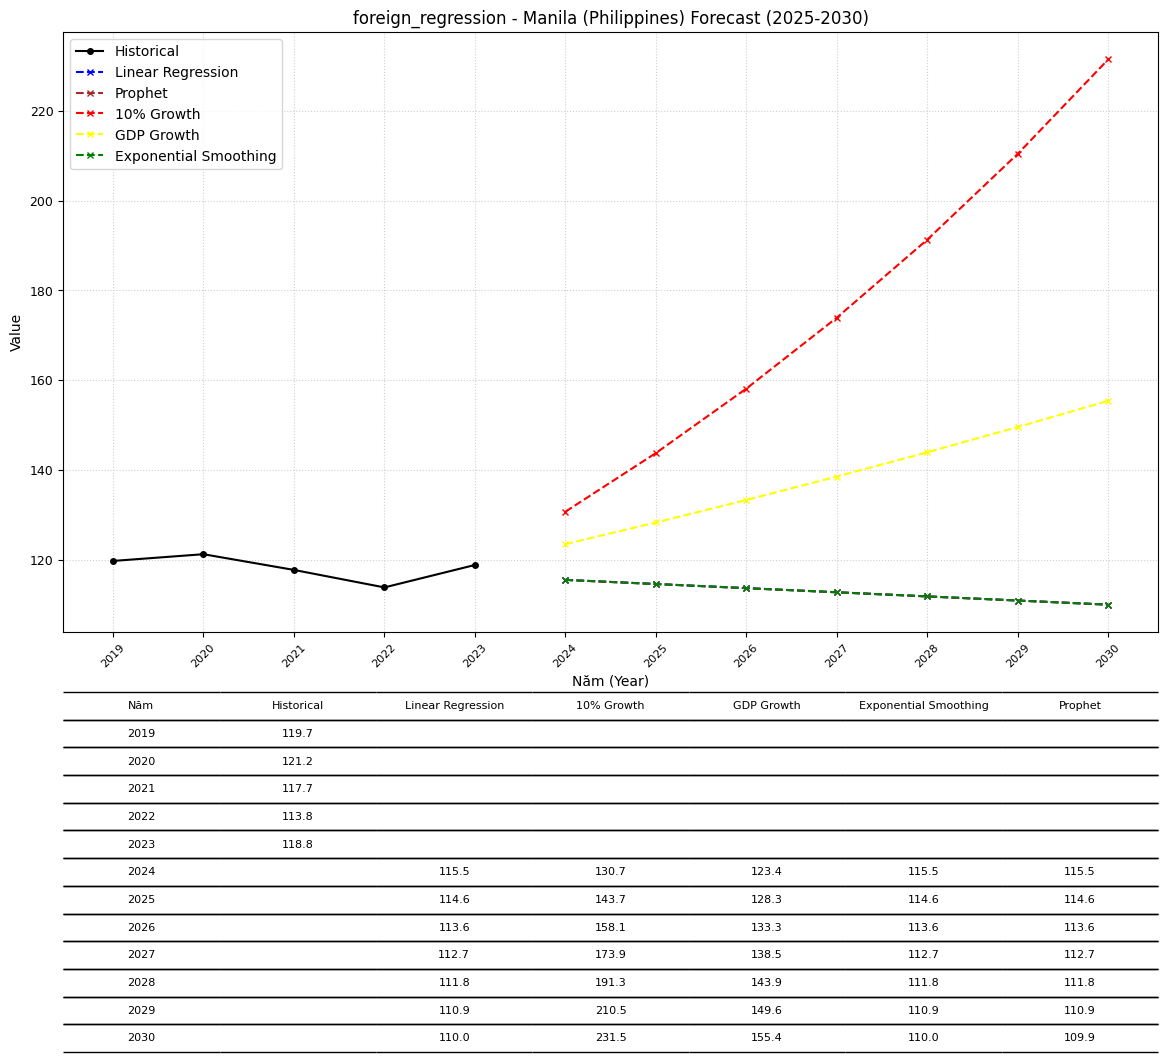

  Saved plot with table: output_plots_with_table\foreign_regression_Kuala_Lumpur_Malaysia_with_table.png


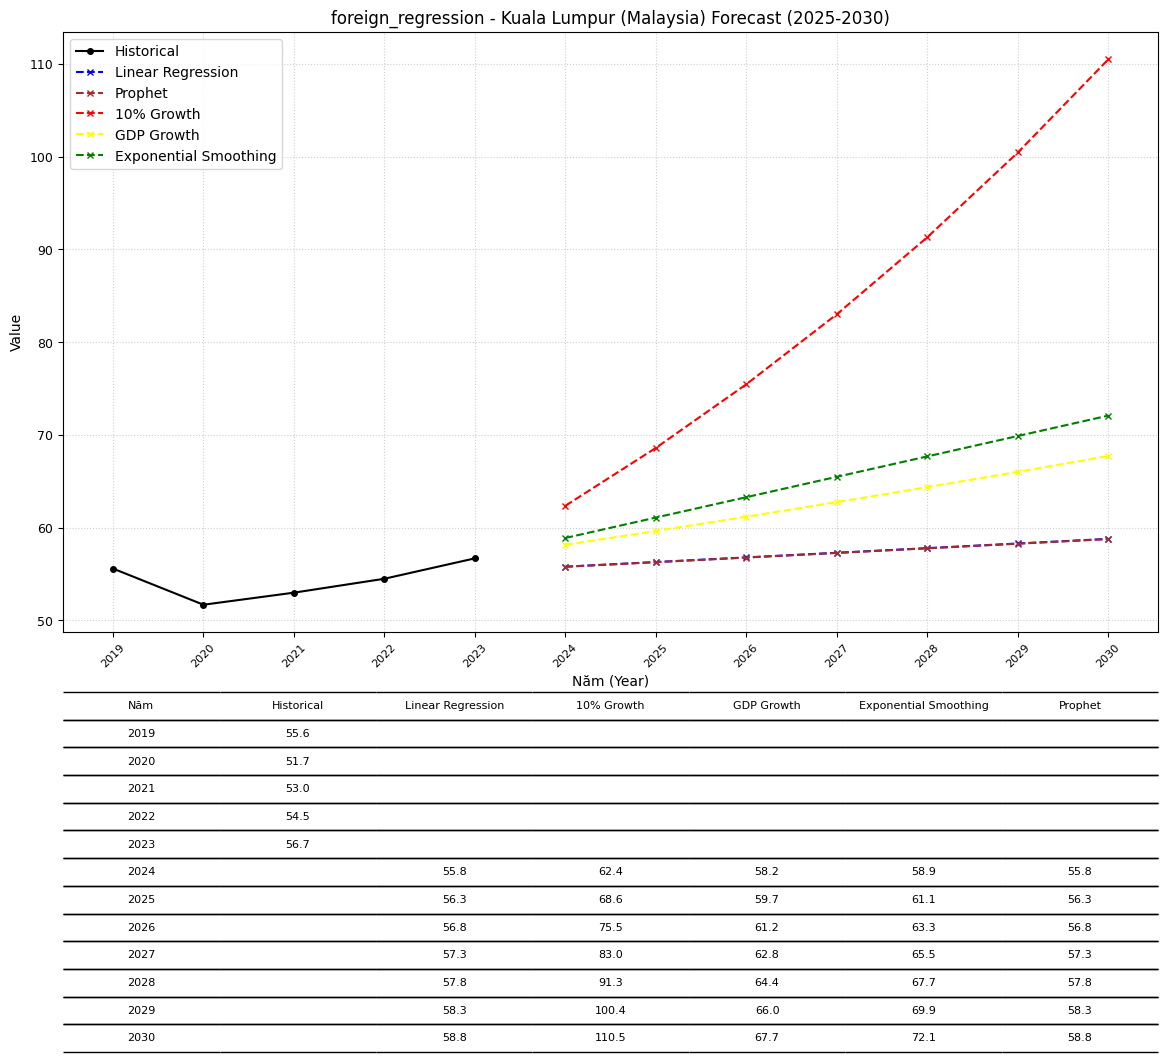

  Saved plot with table: output_plots_with_table\foreign_regression_Hong_Kong_Trung_Quốc_with_table.png


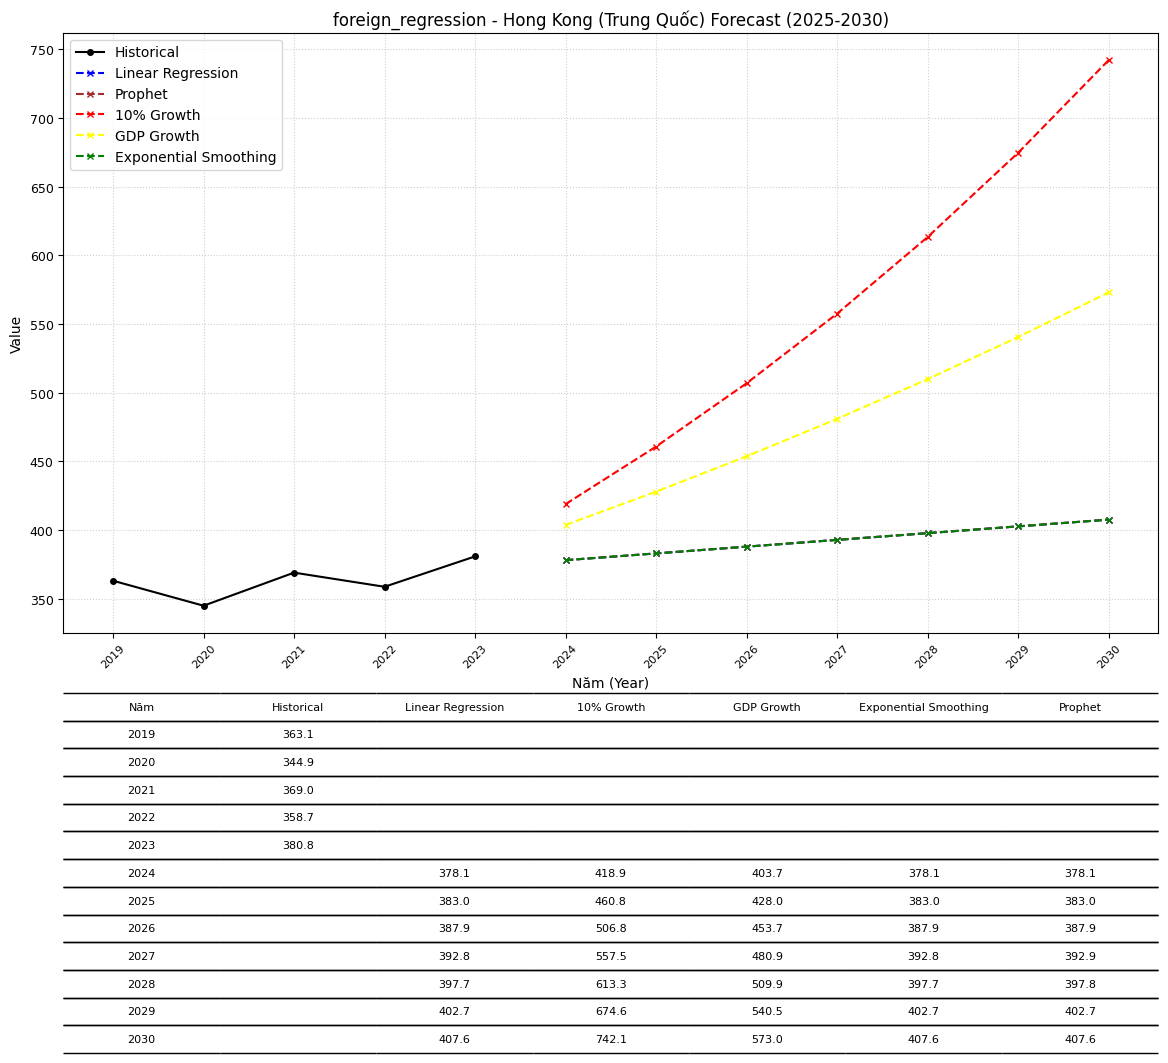

  Saved plot with table: output_plots_with_table\foreign_regression_Seoul_Hàn_Quốc_with_table.png


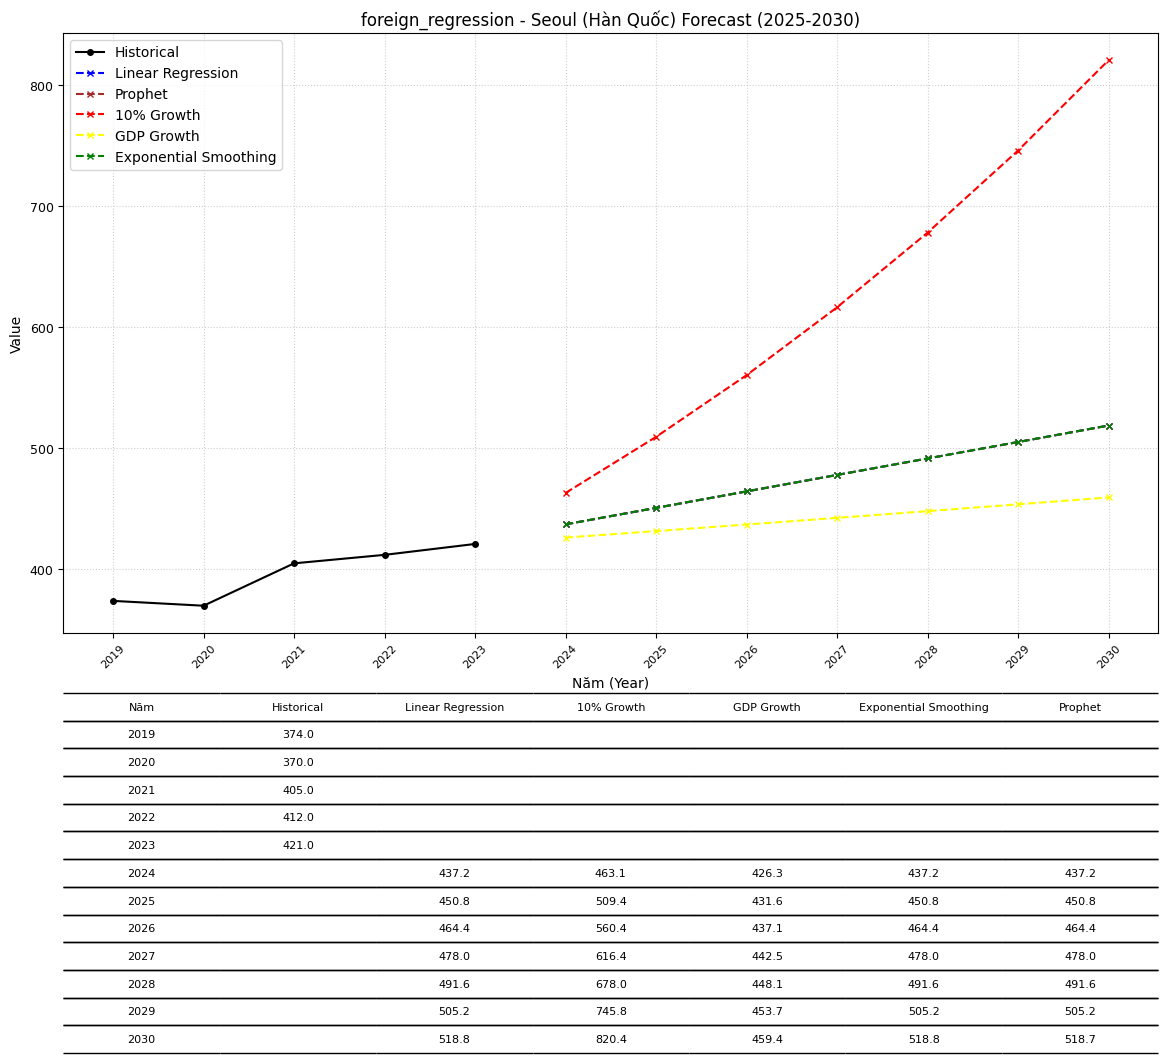

  Saved plot with table: output_plots_with_table\foreign_regression_Taipei_Đài_Loan_with_table.png


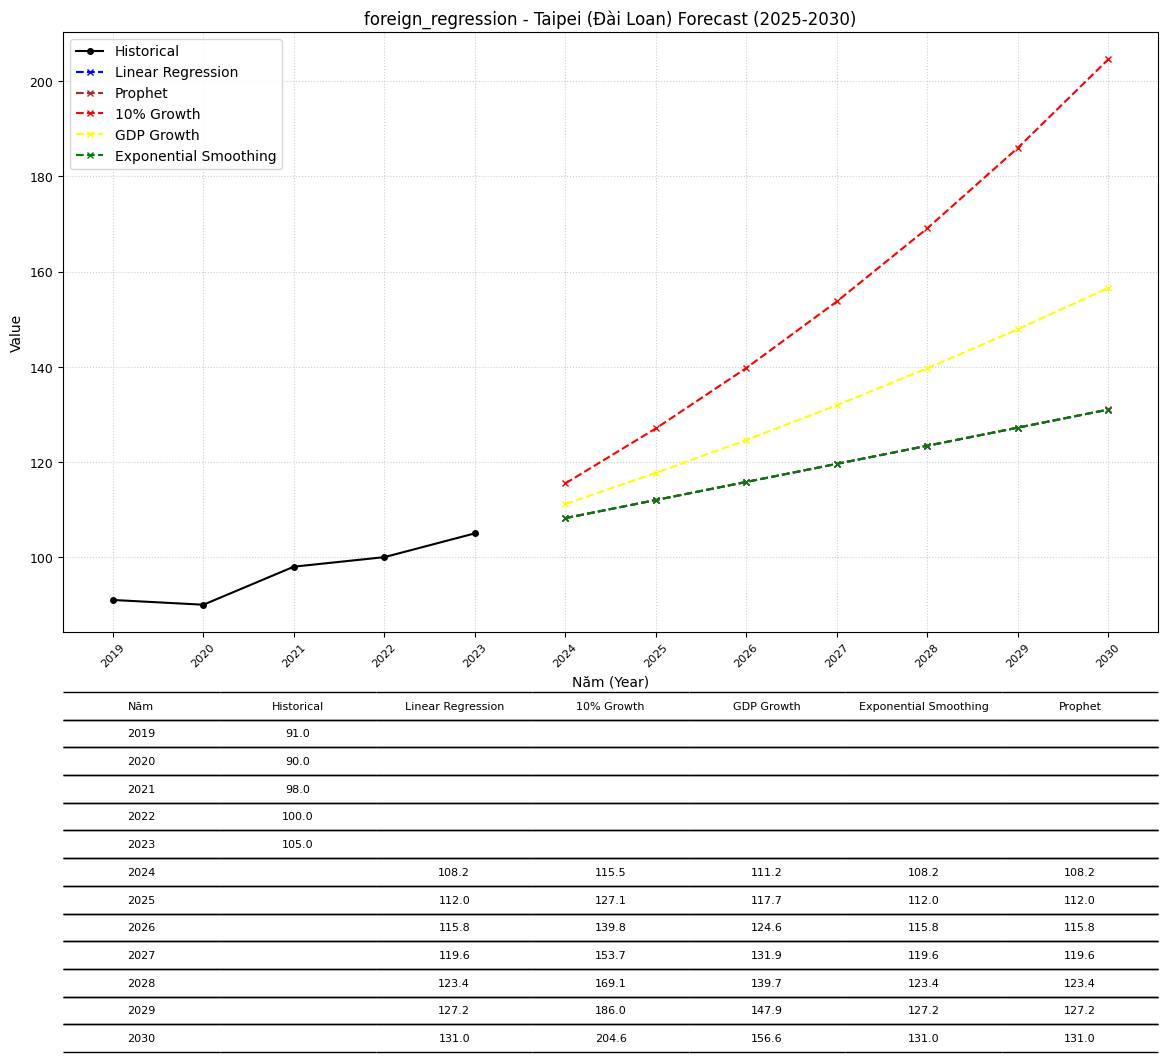

  Saved plot with table: output_plots_with_table\foreign_regression_Thâm_Quyến_Trung_Quốc_with_table.png


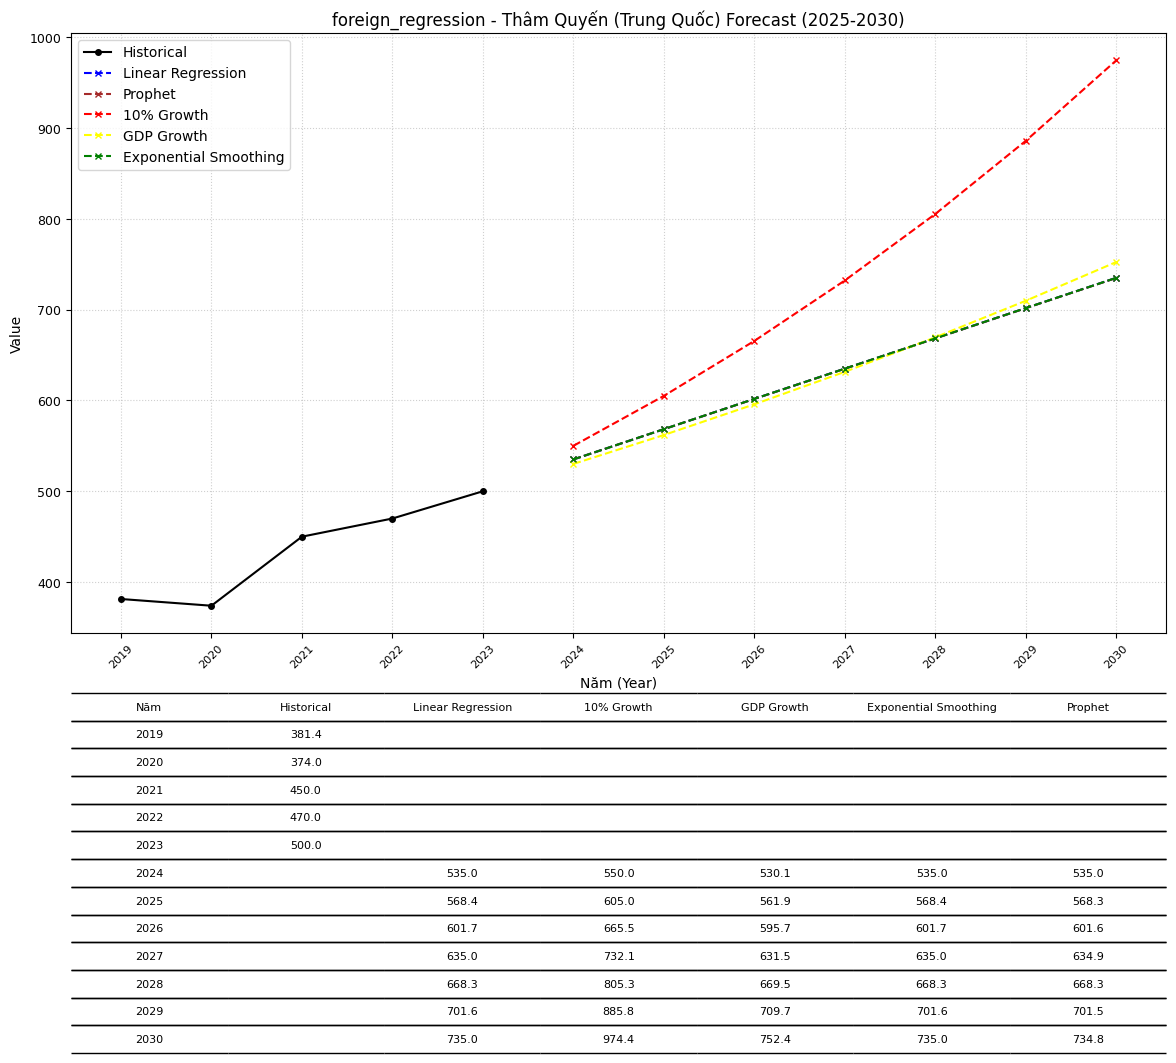

  Saved plot with table: output_plots_with_table\foreign_regression_Osaka_Nhật_Bản_with_table.png


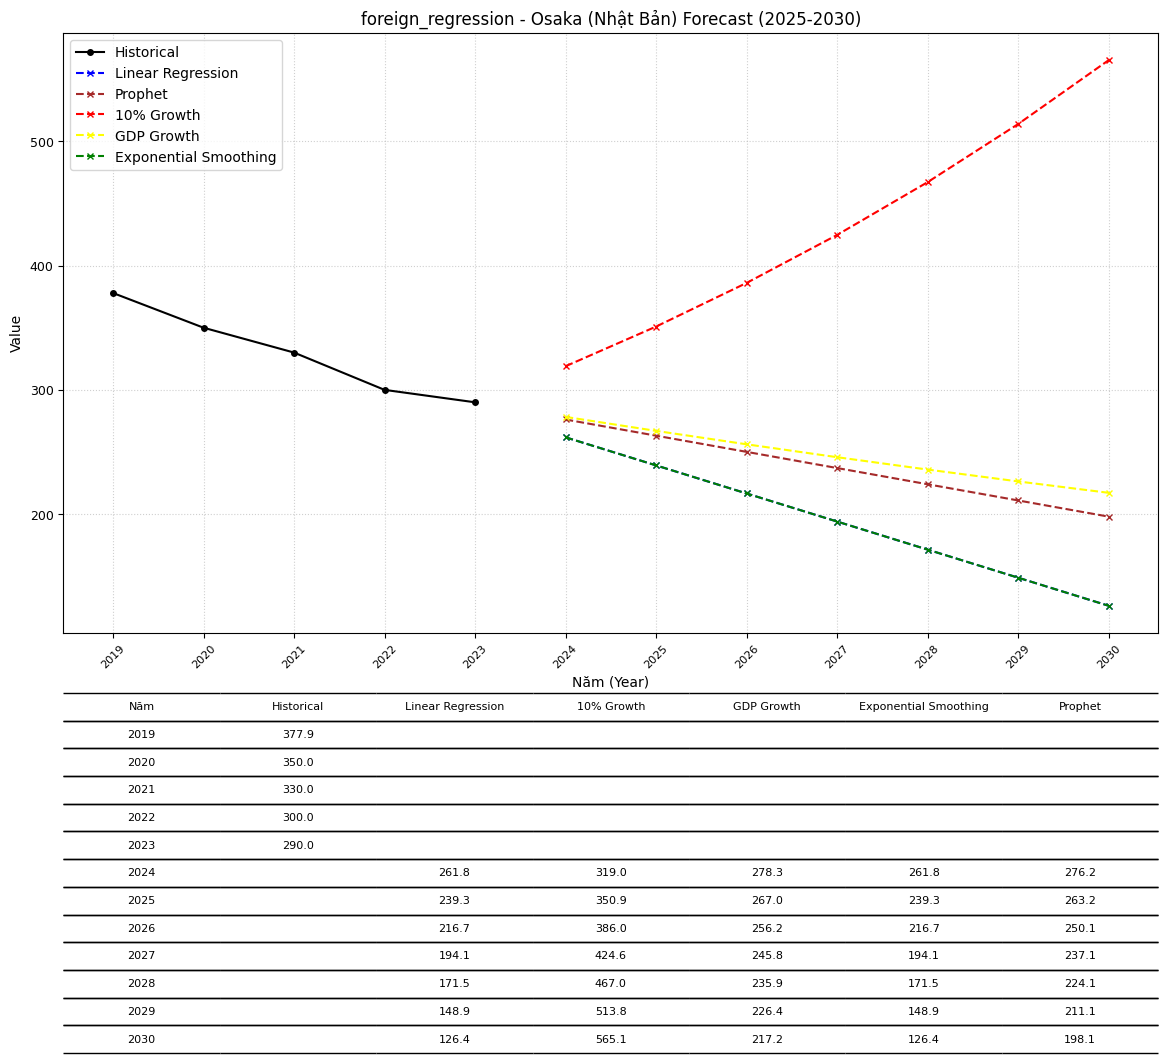

  Saved plot with table: output_plots_with_table\foreign_regression_TP_Hồ_Chí_Minh_Việt_Nam_with_table.png


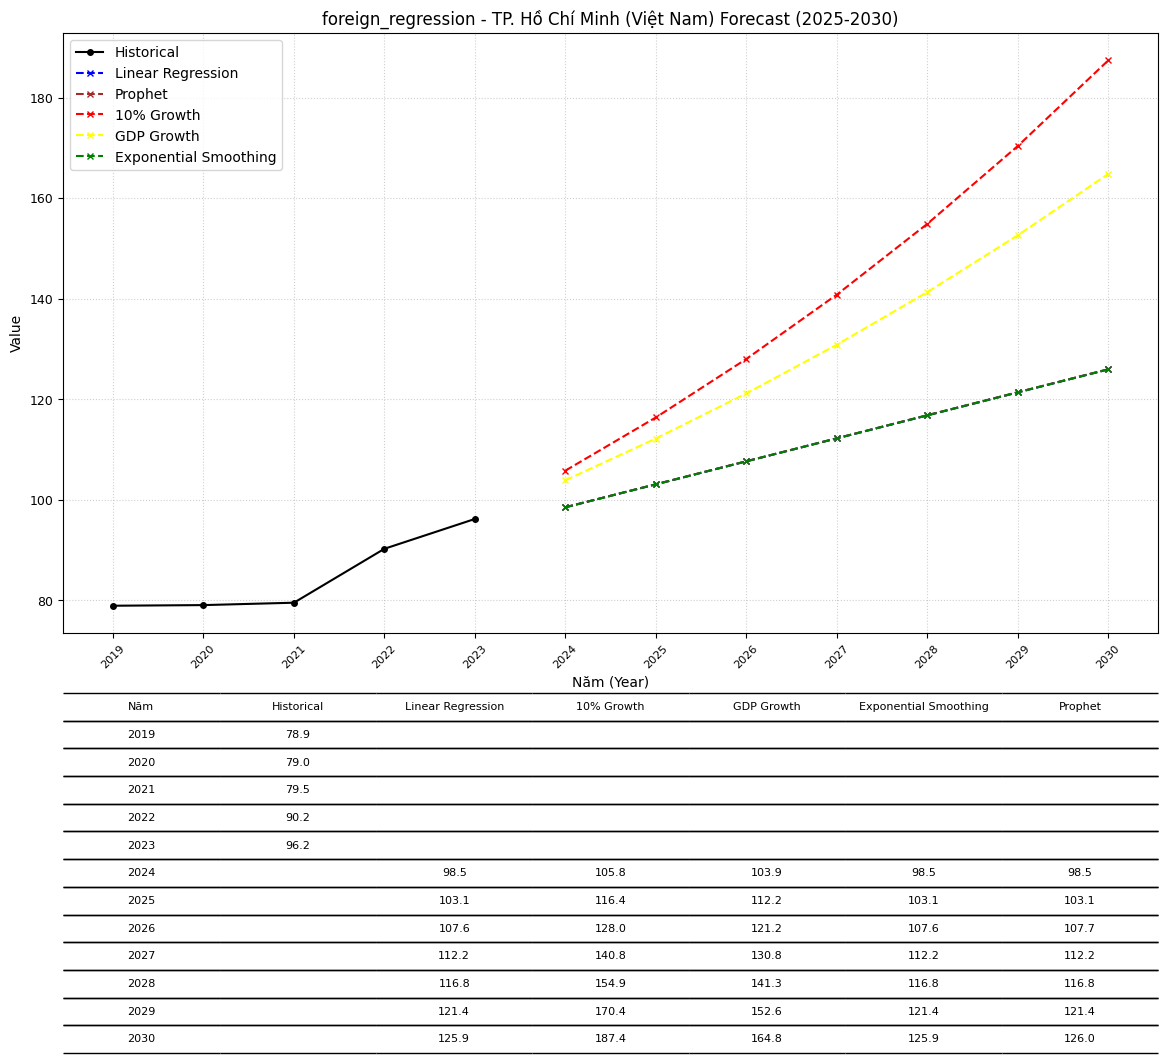


--- All visualizations with tables saved to 'output_plots_with_table' directory ---


In [70]:
for name, forecasts in all_forecasts.items():
    # Use the display name for titles/filenames
    # display_name = "Sáp nhập 3 tỉnh" if name == "Merged" else name
    display_name = "foreign_regression"
    print(f"\nProcessing plots for: {display_name}")
    historical_df = cities_grdp_df # Use original key for lookup

    for feature in features_to_forecast:
        # Check if the feature exists in both historical and forecast data
        if feature not in historical_df.columns:
             print(f"  Skipping plot for '{feature}' in '{display_name}' (historical data missing).")
             continue
        # Also check forecast data existence
        forecast_feature_exists = False
        if feature in forecasts.columns.get_level_values(0):
             forecast_feature_exists = True


        # Prepare data for the table
        hist_series = historical_df[feature].astype(float)
        table_data_list = [hist_series.rename('Historical')]

        if forecast_feature_exists:
            feature_forecasts = forecasts[feature]
            for model_name in models_for_table:
                 # Skip 'Historical' as it's already added
                 if model_name == 'Historical':
                     continue
                 if model_name in feature_forecasts.columns:
                     table_data_list.append(feature_forecasts[model_name].astype(float).rename(model_name))
                 else:
                     # Add an empty series if model forecast doesn't exist
                     table_data_list.append(pd.Series(name=model_name, dtype=float))

            # Combine all series into a DataFrame, filling NaNs for non-overlapping years
            # Only include years present in historical or any forecast
            combined_index = hist_series.index.union(feature_forecasts.index)
            table_df = pd.concat(table_data_list, axis=1).reindex(combined_index).sort_index()
            table_df.index.name = 'Năm'
            table_df = table_df.applymap(lambda x: f'{x:,.1f}' if pd.notna(x) else '') # Format numbers
            table_df = table_df.reset_index() # Make 'Năm' a column for the table function
        else:
            # If no forecast data, just format historical for the table
            print(f"  Feature '{feature}' not found in forecast data for '{display_name}'. Table will only show historical.")
            table_df = hist_series.reset_index()
            table_df.columns = ['Năm', 'Historical']
            table_df['Historical'] = table_df['Historical'].apply(lambda x: f'{x:,.1f}' if pd.notna(x) else '')


        # Start plotting
        # Adjust figsize: slightly wider, taller to give table more room
        fig, ax = plt.subplots(figsize=(15, 12)) # Use fig, ax for easier table positioning

        # --- Plotting Lines and Points (No text labels) ---
        hist_series_plot = hist_series.dropna()
        if not hist_series_plot.empty:
            ax.plot(hist_series_plot.index, hist_series_plot, label='Historical', marker='o', color=colors['Historical'], markersize=4)
            # Removed: ax.text() for historical points

        if forecast_feature_exists:
             feature_forecasts_plot = forecasts[feature]
             for model_name in feature_forecasts_plot.columns:
                 forecast_series_plot = feature_forecasts_plot[model_name].astype(float).dropna()
                 if not forecast_series_plot.empty:
                     color = colors.get(model_name, 'gray')
                     ax.plot(forecast_series_plot.index, forecast_series_plot, label=model_name, marker='x', linestyle='--', color=color, markersize=4)
                     # Removed: ax.text() for forecast points
        # --- End Plotting Lines and Points ---


        ax.set_title(f'{display_name} - {feature} Forecast (2025-2030)')
        ax.set_xlabel('Năm (Year)')
        ax.set_ylabel('Value')
        # Move legend to upper right to avoid potential overlap with steep lines
        ax.legend()
        ax.grid(True, linestyle=':', alpha=0.6)
        # Removed: ax.margins(y=0.1)

        # Adjust x-axis ticks
        all_years_indices = table_df['Năm'].tolist() # Get years from table data
        all_years = sorted(list(set(all_years_indices)))
        plt.xticks(all_years, rotation=45) # Set ticks explicitly to all years in the table
        # ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=len(all_years), integer=True)) # Alternative ticker approach
        ax.tick_params(axis='x', labelsize=8) # Smaller x-tick labels
        ax.tick_params(axis='y', labelsize=9)


        # --- Add Table ---
        if table_df is not None:
             # Adjust plot area: make bottom margin larger, top margin slightly smaller
             plt.subplots_adjust(left=0.2, bottom=0.35, right=0.93, top=0.85)

             # Filter table_df to only include relevant columns for display if needed
             display_cols = ['Năm'] + [col for col in models_for_table if col in table_df.columns]
             table_display_df = table_df[display_cols]


             # Add the table
             the_table = ax.table(cellText=table_display_df.values,
                                  colLabels=table_display_df.columns,
                                  loc='bottom', # Position table below the axes
                                  cellLoc='center',
                                  edges='horizontal',
                                  # Adjust bbox: [left, bottom, width, height]
                                  # bottom value (-0.6) pushes it further down, height (0.4) makes it taller
                                  bbox=[0.0, -0.7, 1.0, 0.6]
                                )

             the_table.auto_set_font_size(False)
             the_table.set_fontsize(8)
             the_table.scale(1, 1.1) # Adjust scale slightly
        else:
             plt.tight_layout() # Use tight layout if no table


        # Create a clean filename using display_name
        clean_feature_name = re.sub(r'[\\/*?:"<>|()]', '', feature)
        clean_feature_name = clean_feature_name.replace(' ', '_').replace('.', '')
        # Use display_name (which might contain spaces) cleaned for filename
        clean_name = display_name.replace(' ', '_')
        filename = f"{clean_name}_{clean_feature_name}_with_table.png"
        filepath = os.path.join(output_dir, filename)

        # Save the figure
        try:
             plt.savefig(filepath, dpi=150, bbox_inches='tight') # Use bbox_inches='tight' to help fit table
             print(f"  Saved plot with table: {filepath}")
        except Exception as e:
             print(f"  Error saving plot {filepath}: {e}")
        plt.show()
        plt.close(fig) # Close the figure explicitly

print(f"\n--- All visualizations with tables saved to '{output_dir}' directory ---")

In [71]:
print("\n--- Exporting Forecast Results to Excel ---")

# Define the output Excel filename
excel_filename = 'forecast_results.xlsx'

try:
    # Create an Excel writer object
    with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
        for name, forecasts_df in all_forecasts.items():
            # Clean the name for the sheet title (Excel sheet names have limitations)
            # Replace invalid chars, limit length (optional but good practice)
            clean_sheet_name = re.sub(r'[\\/*?:"<>|\[\]]', '', name) # Remove invalid Excel sheet chars
            clean_sheet_name = clean_sheet_name[:30] # Limit sheet name length (Excel limit is 31)

            display_name = "Sáp nhập 3 tỉnh" if name == "Merged" else clean_sheet_name

            print(f"  Writing sheet: {display_name}")

            # Prepare DataFrame for export: Reset index to include 'Năm' as a column
            df_to_export = forecasts_df.copy()
            # Flatten MultiIndex columns for easier reading in Excel (optional but helpful)
            # Format: 'Feature - Model'
            df_to_export.columns = [' - '.join(col).strip() for col in df_to_export.columns.values]
            df_to_export = df_to_export.reset_index().rename(columns={'index': 'Năm'})


            # Write the dataframe to a specific sheet
            df_to_export.to_excel(writer, sheet_name=display_name, index=False)

    print(f"\n--- Forecast results successfully exported to '{excel_filename}' ---")

except Exception as e:
    print(f"\nError exporting forecasts to Excel: {e}")
    # You might need to install the engine: pip install openpyxl


--- Exporting Forecast Results to Excel ---
  Writing sheet: foreign_regression

--- Forecast results successfully exported to 'forecast_results.xlsx' ---


In [72]:
print("\n--- Exporting Forecast Results with Historical Data to Excel ---")

# Define the output Excel filename
excel_filename = 'forecast_results_complete.xlsx'

try:
    # Create an Excel writer object
    with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
        for name, forecasts_df in all_forecasts.items():
            # Clean the name for the sheet title
            clean_sheet_name = re.sub(r'[\\/*?:"<>|\[\]]', '', name)
            clean_sheet_name = clean_sheet_name[:30]
            
            display_name = "Sáp nhập 3 tỉnh" if name == "Merged" else clean_sheet_name
            print(f"  Writing sheet: {display_name}")

            # Get historical data for this region
            if name in all_inputs:
                historical_df = all_inputs[name].set_index('Năm').sort_index()
                
                # Filter historical data to include only years 2019-2023
                historical_df = historical_df.loc[historical_df.index.astype(int).isin(range(2019, 2024))]
                
                # Create an empty DataFrame with the same structure as forecasts_df
                # but with historical years as the index
                hist_forecast_format = pd.DataFrame(
                    index=historical_df.index,
                    columns=forecasts_df.columns
                )
                
                # Fill in the actual historical values for each feature
                for feature in forecasts_df.columns.get_level_values(0).unique():
                    if feature in historical_df.columns:
                        # Get the historical values for this feature
                        historical_values = historical_df[feature]
                        
                        # Add historical values to all prediction methods for this feature
                        for method in forecasts_df[feature].columns:
                            hist_forecast_format[(feature, method)] = historical_values
                
                # Combine historical and forecast data
                combined_df = pd.concat([hist_forecast_format, forecasts_df])
                
                # Sort by year
                combined_df = combined_df.sort_index()
            else:
                # If no historical data for this region, just use forecasts
                combined_df = forecasts_df

            # Prepare DataFrame for export
            df_to_export = combined_df.copy()
            
            # Flatten MultiIndex columns for easier reading in Excel
            df_to_export.columns = [' - '.join(col).strip() for col in df_to_export.columns.values]
            df_to_export = df_to_export.reset_index().rename(columns={'index': 'Năm'})

            # Write the dataframe to a specific sheet
            df_to_export.to_excel(writer, sheet_name=display_name, index=False)

    print(f"\n--- Forecast results with historical data successfully exported to '{excel_filename}' ---")

except Exception as e:
    print(f"\nError exporting forecasts to Excel: {e}")


--- Exporting Forecast Results with Historical Data to Excel ---
  Writing sheet: foreign_regression

--- Forecast results with historical data successfully exported to 'forecast_results_complete.xlsx' ---


In [73]:
combined_df

Jakarta (Indonesia)                                      \
       Linear Regression     Prophet  10% Growth  GDP Growth   
2019              199.00  199.000000  199.000000  199.000000   
2020              189.80  189.800000  189.800000  189.800000   
2021              203.70  203.700000  203.700000  203.700000   
2022              202.60  202.600000  202.600000  202.600000   
2023              225.90  225.900000  225.900000  225.900000   
2024              224.18  224.178107  248.490000  238.207608   
2025              230.84  230.829479  273.339000  251.185766   
2026              237.50  237.480850  300.672900  264.871006   
2027              244.16  244.132222  330.740190  279.301854   
2028              250.82  250.801817  363.814209  294.518931   
2029              257.48  257.453189  400.195630  310.565073   
2030              264.14  264.104561  440.215193  327.485450   

                           Bangkok (Thái Lan)                          \
     Exponential Smoothing  Linear Regression     Prophet  10% Growth   
2019            199.000000             173.80  173.800000  173.800000   
2020            189.800000             150.00  150.000000  150.000000   
2021            203.700000             155.00  155.000000  155.000000   
2022            202.600000             149.00  149.000000  149.000000   
2023            225.900000             154.00  154.000000  154.000000   
2024            224.180001             144.18  144.182796  169.400000   
2025            230.840001             140.12  140.128186  186.340000   
2026            237.500001             136.06  136.073576  204.974000   
2027            244.160001             132.00  132.018966  225.471400   
2028            250.820002             127.94  127.953248  248.018540   
2029            257.480002             123.88  123.898638  272.820394   
2030            264.140002             119.82  119.844028  300.102433   

                                        ...  Osaka (Nhật Bản)              \
      GDP Growth Exponential Smoothing  ... Linear Regression     Prophet   
2019  173.800000            173.800000  ...            377.90  377.900000   
2020  150.000000            150.000000  ...            350.00  350.000000   
2021  155.000000            155.000000  ...            330.00  330.000000   
2022  149.000000            149.000000  ...            300.00  300.000000   
2023  154.000000            154.000000  ...            290.00  290.000000   
2024  152.059904            144.180000  ...            261.84  276.168576   
2025  150.144250            140.120000  ...            239.26  263.155283   
2026  148.252729            136.060000  ...            216.68  250.141990   
2027  146.385038            132.000000  ...            194.10  237.128697   
2028  144.540875            127.940001  ...            171.52  224.079751   
2029  142.719946            123.880001  ...            148.94  211.066459   
2030  140.921957            119.820001  ...            126.36  198.053166   

                                                   TP. Hồ Chí Minh (Việt Nam)  \
      10% Growth  GDP Growth Exponential Smoothing          Linear Regression   
2019  377.900000  377.900000            377.900000                  78.914615   
2020  350.000000  350.000000            350.000000                  79.039115   
2021  330.000000  330.000000            330.000000                  79.515269   
2022  300.000000  300.000000            300.000000                  90.243423   
2023  290.000000  290.000000            290.000000                  96.176500   
2024  319.000000  278.268807            261.839871                  98.496208   
2025  350.900000  267.012169            239.259822                 103.069016   
2026  385.990000  256.210889            216.679773                 107.641823   
2027  424.589000  245.846547            194.099724                 112.214631   
2028  467.047900  235.901467            171.519675                 116.787439   
2029  513.752690  226.358689      

In [74]:
target_city = 'TP. Hồ Chí Minh (Việt Nam)'
last_historical_year = 2023 

In [75]:
prediction_start_year = last_historical_year + 1
prediction_start_year

2024

In [76]:
all_cities_in_df = combined_df.columns.get_level_values(0).unique().tolist()
all_models_in_df = combined_df.columns.get_level_values(1).unique().tolist()

if target_city not in all_cities_in_df:
	raise(f"Target city '{target_city}' not found in the DataFrame columns.")

In [77]:
all_cities_in_df

['Jakarta (Indonesia)',
 'Bangkok (Thái Lan)',
 'Singapore (Singapore)',
 'Manila (Philippines)',
 'Kuala Lumpur (Malaysia)',
 'Hong Kong (Trung Quốc)',
 'Seoul (Hàn Quốc)',
 'Taipei (Đài Loan)',
 'Thâm Quyến (Trung Quốc)',
 'Osaka (Nhật Bản)',
 'TP. Hồ Chí Minh (Việt Nam)']

In [78]:
all_models_in_df

['Linear Regression',
 'Prophet',
 '10% Growth',
 'GDP Growth',
 'Exponential Smoothing']

In [79]:
other_cities_in_df = [city for city in all_cities_in_df if city != target_city]
other_cities_in_df

['Jakarta (Indonesia)',
 'Bangkok (Thái Lan)',
 'Singapore (Singapore)',
 'Manila (Philippines)',
 'Kuala Lumpur (Malaysia)',
 'Hong Kong (Trung Quốc)',
 'Seoul (Hàn Quốc)',
 'Taipei (Đài Loan)',
 'Thâm Quyến (Trung Quốc)',
 'Osaka (Nhật Bản)']

In [80]:
for model_name in all_models_in_df:
	print(f"\n--- Analyzing Model: {model_name} ---")
	
	cities_overtaken_this_model = [] # Stores {'city': other_city_name, 'year': overtake_year}

	# Extract data for the current model using .xs
	# This creates a DataFrame with Year as index and City Names as columns for the current model
	try:
		model_specific_df = combined_df.xs(model_name, level=1, axis=1)
	except KeyError:
		print(f"Could not extract data for model '{model_name}'. Skipping.")
		continue

	if target_city not in model_specific_df.columns:
		print(f"Target city '{target_city}' data not found for model '{model_name}'. Skipping.")
		continue
	
	hcm_grdp_series = model_specific_df[target_city]
	
	for other_city_name in other_cities_in_df:
		if other_city_name not in model_specific_df.columns:
			# This might happen if some cities don't have predictions for all models
			print(f"City '{other_city_name}' data not found for model '{model_name}'. Skipping comparison.")
			continue

		other_city_grdp_series = model_specific_df[other_city_name]
		
		# Get GRDP in the last historical year
		grdp_hcm_historical = hcm_grdp_series.get(last_historical_year)
		grdp_other_historical = other_city_grdp_series.get(last_historical_year)

		if pd.isna(grdp_hcm_historical) or pd.isna(grdp_other_historical):
			print(f"Warning: Missing historical GRDP data for {last_historical_year} for '{target_city}' or '{other_city_name}' with model '{model_name}'. Skipping this city for overtaking check.")
			continue

		# Condition: HCM was behind or equal to the other city in the last historical year
		if grdp_hcm_historical <= grdp_other_historical:
			# Iterate through future years to find the overtaking point
			for year_idx in range(prediction_start_year, model_specific_df.index.max() + 1):
				if year_idx not in hcm_grdp_series.index or year_idx not in other_city_grdp_series.index:
					continue # Skip if data for this year is missing

				grdp_hcm_future = hcm_grdp_series.get(year_idx)
				grdp_other_future = other_city_grdp_series.get(year_idx)

				if pd.isna(grdp_hcm_future) or pd.isna(grdp_other_future):
					print(f"Warning: Missing future GRDP data for {year_idx} for '{target_city}' or '{other_city_name}' with model '{model_name}'. Cannot determine overtaking for further years.")
					break 
				
				if grdp_hcm_future > grdp_other_future:
					cities_overtaken_this_model.append({
						'city': other_city_name, 
						'year': year_idx,
						'hcm_grdp_at_overtake': grdp_hcm_future,
						'other_grdp_at_overtake': grdp_other_future
					})
					break # Found the first overtaking year for this city, move to the next city

	if not cities_overtaken_this_model:
		print(f"For model '{model_name}', {target_city} is not predicted to overtake any new cities (that it was behind or equal to in {last_historical_year}).")
		continue


--- Analyzing Model: Linear Regression ---

--- Analyzing Model: Prophet ---

--- Analyzing Model: 10% Growth ---
For model '10% Growth', TP. Hồ Chí Minh (Việt Nam) is not predicted to overtake any new cities (that it was behind or equal to in 2023).

--- Analyzing Model: GDP Growth ---

--- Analyzing Model: Exponential Smoothing ---


In [81]:
# Create a directory for output plots if it doesn't exist
import os
output_dir = 'output_plots_with_table'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")
else:
    print(f"Directory already exists: {output_dir}")

Directory already exists: output_plots_with_table


For model 'Exponential Smoothing', TP. Hồ Chí Minh (Việt Nam) is predicted to overtake:
- Bangkok (Thái Lan) in the year 2030
- Manila (Philippines) in the year 2028


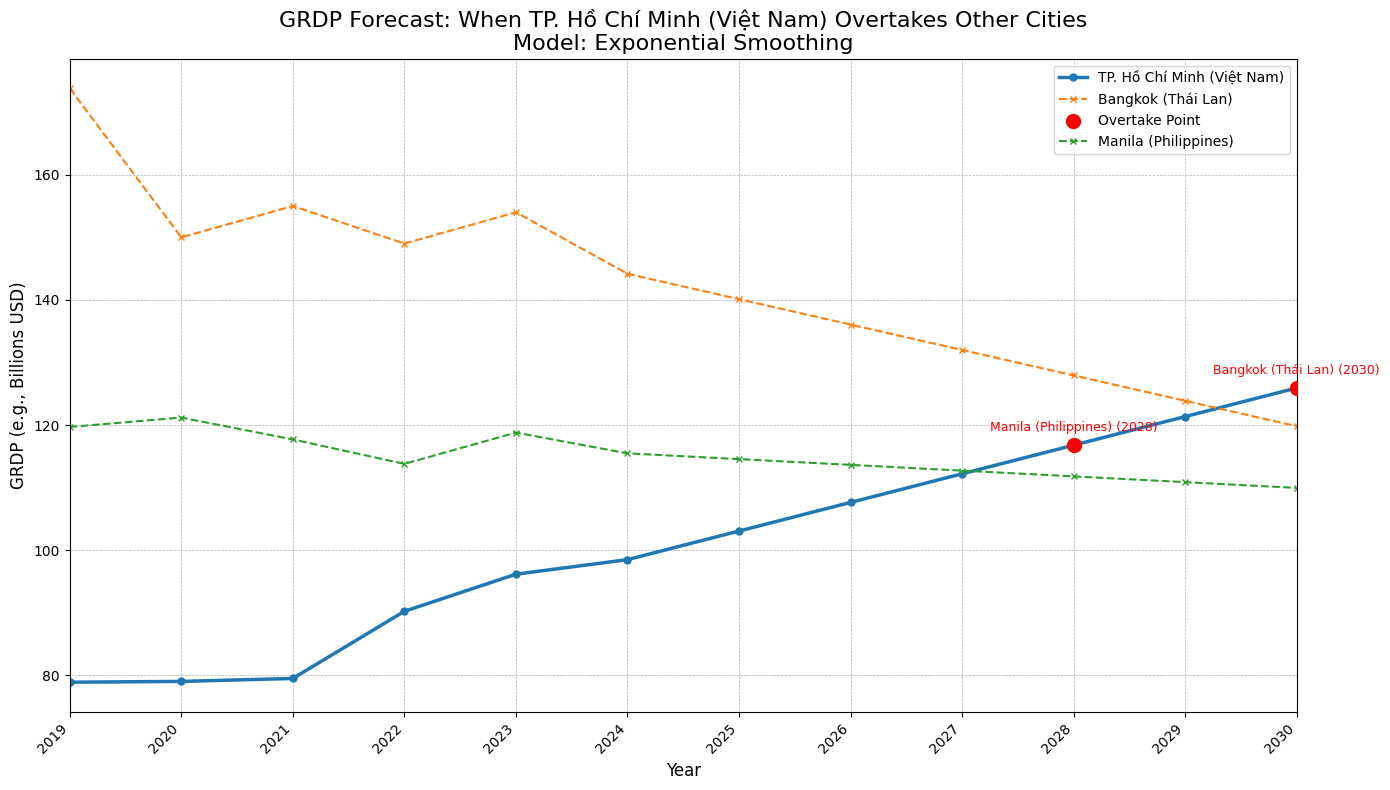

In [82]:
# --- Plotting ---
plt.figure(figsize=(14, 8))

# Plot HCM's GRDP
plt.plot(hcm_grdp_series.index, hcm_grdp_series.values, label=f'{target_city}', linewidth=2.5, marker='o', markersize=5)

print(f"For model '{model_name}', {target_city} is predicted to overtake:")

# Sort cities by overtaking year for a more logical legend/plot if desired, though order of plotting doesn't strictly matter here
# cities_overtaken_this_model.sort(key=lambda x: x['year'])

plotted_overtake_marker_label = False
for info in cities_overtaken_this_model:
	city_to_plot = info['city']
	overtake_year = info['year']
	print(f"- {city_to_plot} in the year {overtake_year}")
	
	if city_to_plot in model_specific_df.columns:
		other_city_plot_series = model_specific_df[city_to_plot]
		plt.plot(other_city_plot_series.index, other_city_plot_series.values, label=f'{city_to_plot}', linestyle='--', marker='x', markersize=5)
		
		hcm_val_at_overtake = hcm_grdp_series.get(overtake_year)
		if hcm_val_at_overtake is not None:
			label_for_marker = None
			if not plotted_overtake_marker_label: # Label only the first marker type to avoid legend clutter
					label_for_marker = f'Overtake Point'
					plotted_overtake_marker_label = True
			plt.scatter(overtake_year, hcm_val_at_overtake, color='red', s=100, zorder=5, label=label_for_marker)
			plt.annotate(f'{city_to_plot} ({overtake_year})', 
							(overtake_year, hcm_val_at_overtake), 
							textcoords="offset points", 
							xytext=(0,10), 
							ha='center', color='red', fontsize=9)

plt.title(f'GRDP Forecast: When {target_city} Overtakes Other Cities\nModel: {model_name}', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GRDP (e.g., Billions USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Ensure all years in the dataframe index are potential ticks
plt.xticks(ticks=model_specific_df.index, rotation=45, ha="right")
plt.xlim(model_specific_df.index.min(), model_specific_df.index.max()) # Set x-axis limits

plt.tight_layout()

# Save the plot to the output directory
plt.savefig(f'{output_dir}/{target_city}_overtaking_{model_name}.png', dpi=300, bbox_inches='tight')
plt.show()


--- Generating GRDP Growth Chart for Model: Linear Regression ---
Saved plot to: output_plots_with_table\grdp_forecast_Linear_Regression.png


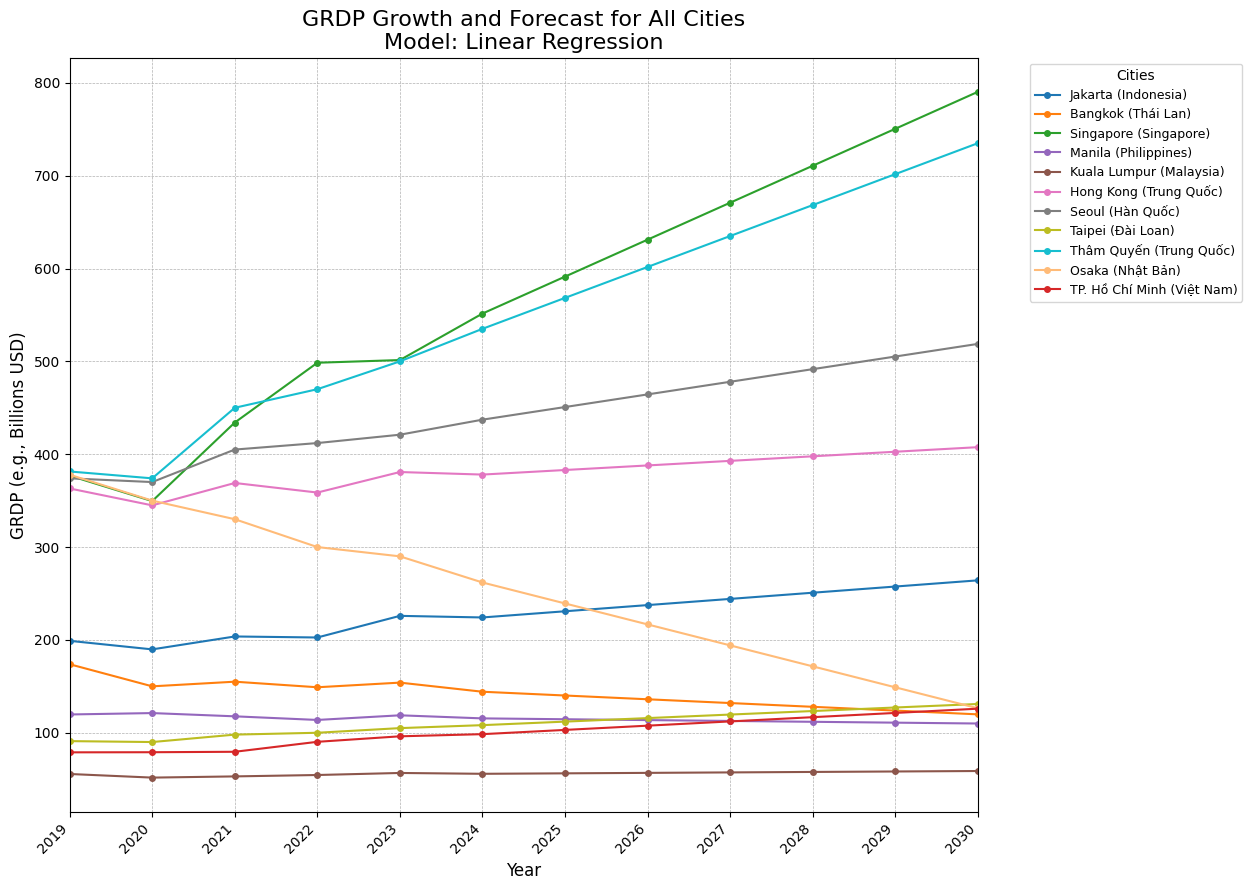


--- Generating GRDP Growth Chart for Model: Prophet ---
Saved plot to: output_plots_with_table\grdp_forecast_Prophet.png


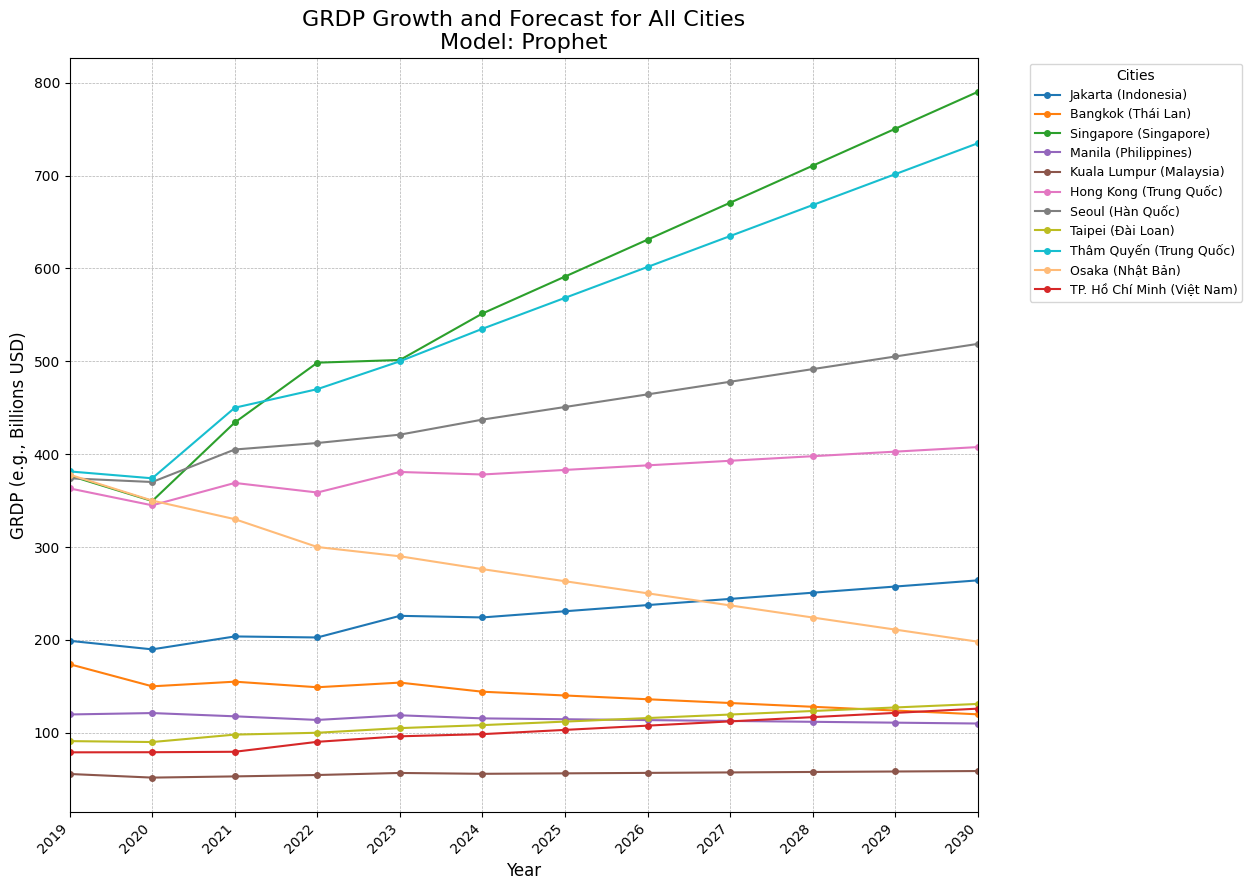


--- Generating GRDP Growth Chart for Model: 10% Growth ---
Saved plot to: output_plots_with_table\grdp_forecast_10%_Growth.png


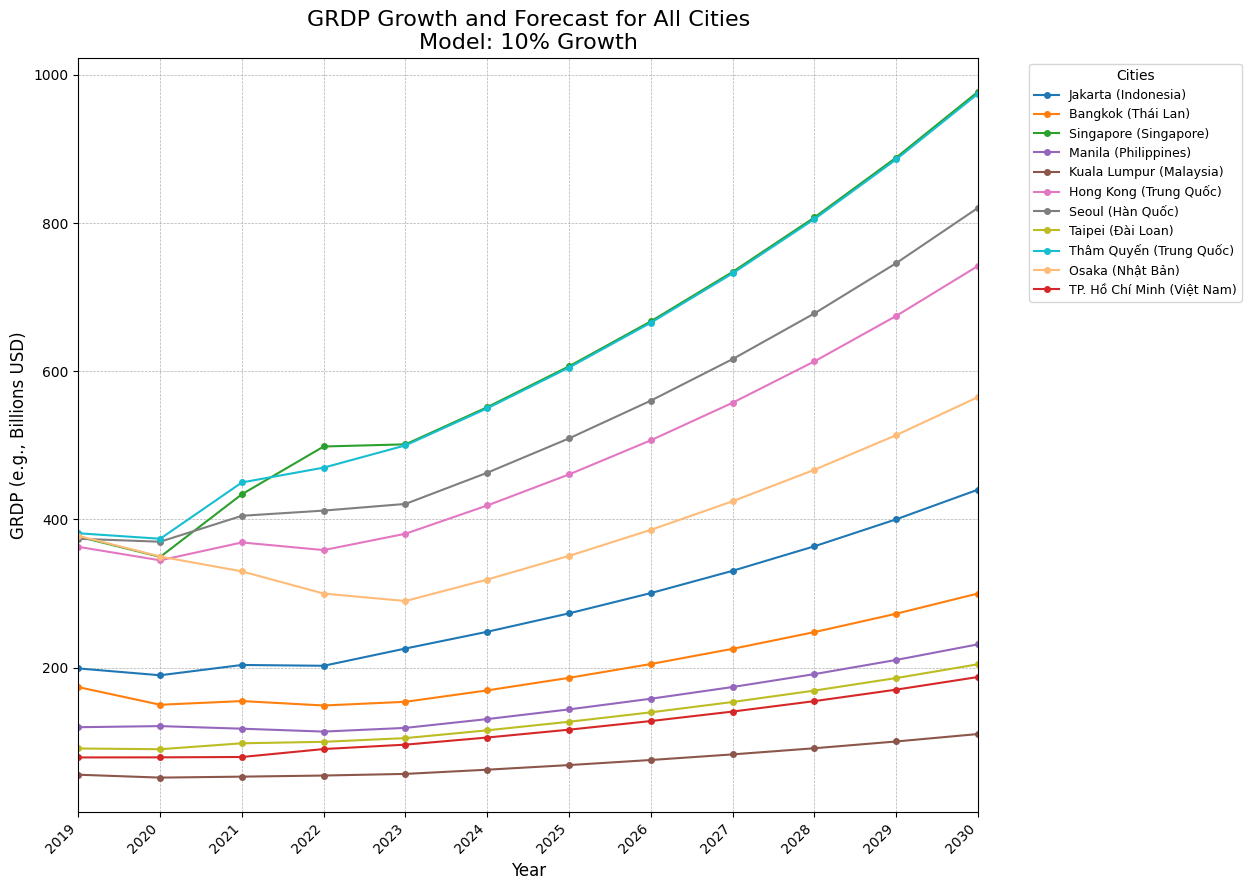


--- Generating GRDP Growth Chart for Model: GDP Growth ---
Saved plot to: output_plots_with_table\grdp_forecast_GDP_Growth.png


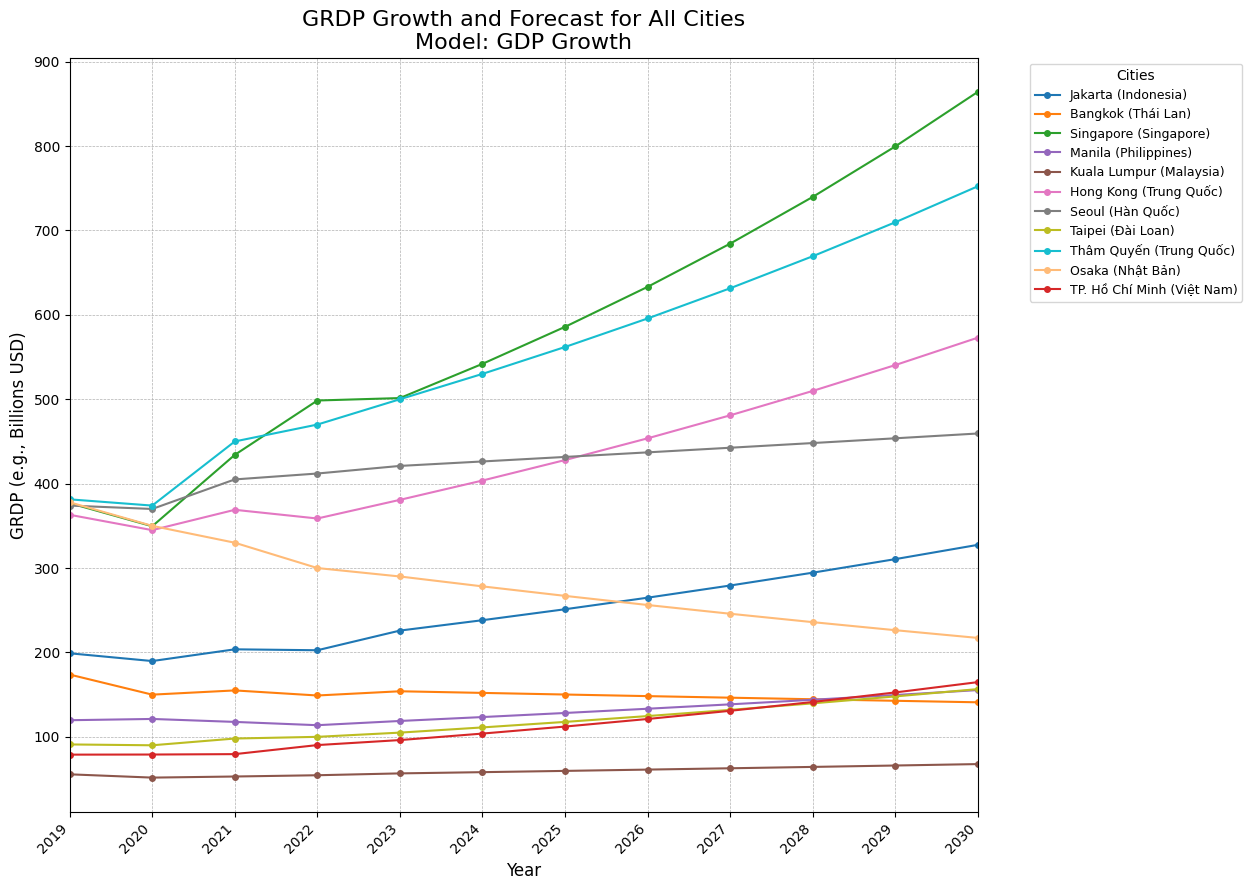


--- Generating GRDP Growth Chart for Model: Exponential Smoothing ---
Saved plot to: output_plots_with_table\grdp_forecast_Exponential_Smoothing.png


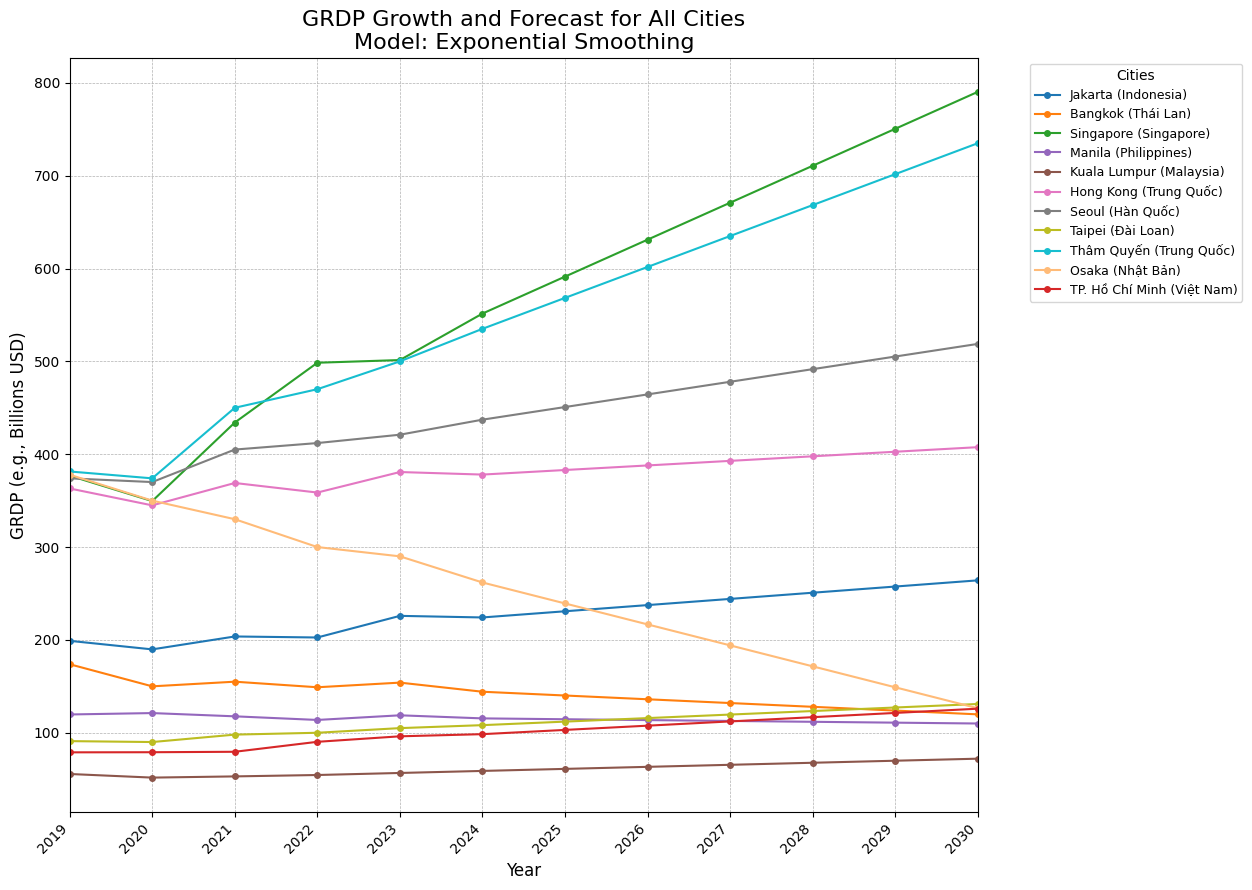


--- All charts generated and data exported. ---


In [83]:
# Create a dictionary to map city names to colors
city_colors = {city: color for city, color in zip(all_cities_in_df, distinct_colors)}

for model_name in all_models_in_df:
    print(f"\n--- Generating GRDP Growth Chart for Model: {model_name} ---")
    
    plt.figure(figsize=(15, 9)) # Adjust figure size as needed
    
    # Extract data for the current model using .xs
    # This creates a DataFrame with Year as index and City Names as columns for the current model
    try:
        model_specific_df = combined_df.xs(model_name, level=1, axis=1)
    except KeyError:
        print(f"Could not extract data for model '{model_name}'. Skipping chart generation.")
        continue

    if model_specific_df.empty:
        print(f"No data found for model '{model_name}'. Skipping chart generation.")
        continue
        
    for city_name in all_cities_in_df:
        if city_name in model_specific_df.columns:
            city_grdp_series = model_specific_df[city_name]
            if not city_grdp_series.dropna().empty: # Plot only if there's data
                plt.plot(city_grdp_series.index, city_grdp_series.values, 
                         label=city_name, marker='o', markersize=4, linestyle='-',
                         color=city_colors[city_name])  # Use the assigned color
        # else:
            # print(f"City '{city_name}' not found in data for model '{model_name}'. Will not be plotted for this model.")

    plt.title(f'GRDP Growth and Forecast for All Cities\nModel: {model_name}', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('GRDP (e.g., Billions USD)', fontsize=12)
    
    # Create legend outside the plot if many cities
    # Adjust bbox_to_anchor and loc as needed
    if len(all_cities_in_df) > 10: # Arbitrary threshold for moving legend outside
            plt.legend(title='Cities', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    else:
        plt.legend(title='Cities', fontsize=10)
        
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Ensure all years in the dataframe index are potential ticks
    # Use the index of the model_specific_df which is guaranteed to exist if we reached here
    plt.xticks(ticks=model_specific_df.index, rotation=45, ha="right")
    plt.xlim(model_specific_df.index.min(), model_specific_df.index.max()) # Set x-axis limits
    
    plt.tight_layout(rect=[0, 0, 0.85, 1] if len(all_cities_in_df) > 10 else None) # Adjust rect if legend is outside
    
    # Save the plot to the output directory
    output_filename = os.path.join(output_dir, f'grdp_forecast_{model_name.replace(" ", "_")}.png')
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Saved plot to: {output_filename}")
    
    plt.show()

print("\n--- All charts generated and data exported. ---")

In [84]:
# Export the combined dataframe to CSV in the output directory
csv_filename = os.path.join('grdp_forecast_data.csv')
combined_df.to_csv(csv_filename)
print(f"\nExported forecast data to: {csv_filename}")


Exported forecast data to: grdp_forecast_data.csv
